In [1]:
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np
import re
from tqdm import tqdm
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["font.family"] = 'Malgun Gothic'

In [2]:
df1 = pd.read_csv('데이터/df1.csv')
df2 = pd.read_csv('데이터/df2.csv')

In [3]:
#sales에 NA인 국가 제거 
df2 = df2.dropna(subset=['국가'])

In [4]:
print(df1['국가'].nunique())   #총 국가 
print(df2['국가'].nunique())   #거래 국가 = 34개 (비거래 국가 = 29개)

63
34


In [5]:
#2022년 잘 필터링됐는지 보기 
print(df1['년'].unique())   
print(df2['년'].unique()) 

[2022]
[2022]


## 이상치 제거 

In [6]:
df2

,날짜,품목그룹,수량,단가,년,월,일,국가,환율,실제판매금액,이동평균_5일,이동평균_10일,이동평균_20일,계절,요일,판매금액_대비_수량,이전거래후_경과_일수,이전기간_대비_매출증가율
0,2022-08-09,Accessories,2,1460,2022,8,9,남아프리카공화국,1350,3942000,0.0,0.0,18072315.0,여름,Tuesday,5.073567e-07,NaN,NaN
1,2022-08-09,Accessories,2,730,2022,8,9,남아프리카공화국,1350,1971000,0.0,0.0,18275760.0,여름,Tuesday,1.014713e-06,0.0,-0.500000
2,2022-11-04,Antenna / RF Couple,1,240,2022,11,4,남아프리카공화국,1350,324000,NaN,NaN,NaN,가을,Friday,3.086420e-06,87.0,-0.835616
3,2022-11-04,Shield box,1,2345,2022,11,4,남아프리카공화국,1350,3165750,NaN,NaN,NaN,가을,Friday,3.158809e-07,0.0,8.770833
4,2022-11-09,Others,1,3300,2022,11,9,네덜란드,1350,4455000,NaN,NaN,NaN,가을,Wednesday,2.244669e-07,89.0,-0.907821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224,2022-09-08,Shield box,1,11650,2022,9,8,홍콩,1350,15727500,6949800.0,4989600.0,12099577.5,가을,Thursday,6.358290e-08,34.0,-0.851623
1225,2022-09-16,Antenna / RF Couple,15,150,2022,9,16,홍콩,1350,3037500,0.0,0.0,0.0,가을,Friday,4.938272e-06,8.0,-0.806867
1226,2022-11-10,Antenna / RF Couple,2,400,2022,11,10,홍콩,1350,1080000,NaN,NaN,NaN,가을,Thursday,1.851852e-06,26.0,inf
1227,2022-11-11,Antenna / RF Couple,9,150,2022,11,11,홍콩,1350,1822500,NaN,NaN,NaN,가을,Friday,4.938272e-06,1.0,0.687500


In [7]:
sales_country = df2.groupby('국가')['실제판매금액'].sum()
sales_country = pd.DataFrame(sales_country)
sales_country = sales_country.reset_index()
sales_country = sales_country.sort_values(by='실제판매금액', ascending=False)
sales_country

,국가,실제판매금액
8,미국,2322006750
24,중국,732940650
2,대만,358665300
33,홍콩,311728500
23,일본,241226100
9,베트남,208219950
3,덴마크,205343100
7,멕시코,180090000
21,인도,168095250
14,싱가포르,152112600


In [8]:
sales_country.to_csv('데이터/sales_country.csv', index=False)

In [9]:
Q1 = sales_country['실제판매금액'].quantile(0.25)
Q3 = sales_country['실제판매금액'].quantile(0.75)
IQR = Q3 - Q1

large = sales_country[sales_country['실제판매금액'] > (Q3 + 1.5 * IQR)]
small = sales_country[sales_country['실제판매금액'] < (Q1 - 1.5 * IQR)]

In [10]:
large

,국가,실제판매금액
8,미국,2322006750
24,중국,732940650


In [11]:
small

,국가,실제판매금액


In [13]:
#이상치 제거 (미국, 중국)
countries_to_remove = ['미국', '중국']
df2= df2[~df2['국가'].isin(countries_to_remove)]

In [14]:
print(df2['국가'].nunique())
print(df2['국가'].unique())      #34개에서 32개로 줄어듦

32
['남아프리카공화국' '네덜란드' '대만' '덴마크' '독일' '루마니아' '말레이시아' '멕시코' '베트남' '브라질' '스웨덴'
 '스위스' '슬로베니아' '싱가포르' '아르헨티나' '아일랜드' '영국' '오스트리아' '우크라이나' '이스라엘' '인도'
 '인도네시아' '일본' '캐나다' '태국' '폴란드' '프랑스' '핀란드' '필리핀' '헝가리' '호주' '홍콩']


## 결측치 처리 

In [15]:
#merge df1, df2_filtered
data = pd.merge(df2, df1, on=['국가', '년', '월'], how='left')
data = data.sort_values(by=['국가', '년', '월', '일'])

In [16]:
data.isna().sum()

날짜                 0
품목그룹               0
수량                 0
단가                 0
년                  0
월                  0
일                  0
국가                 0
환율                 0
실제판매금액             0
이동평균_5일          168
이동평균_10일         176
이동평균_20일         187
계절                 0
요일                 0
판매금액_대비_수량         0
이전거래후_경과_일수        1
이전기간_대비_매출증가율    104
수출 금액             16
수입 금액             16
무역수지              16
무역비율              24
0~14세인구비율         95
15~64세인구비율        95
65세이상인구비율         95
연간_인구증가비율         95
총인구수              95
GDP               24
국민총소득             95
1인당국민총소득          95
1인GDP             24
경제성장률             24
수출 무역의존도          24
수입 무역의존도          24
1인당국민총소득_비율       95
1인당GDP_비율         24
dtype: int64

<Axes: >

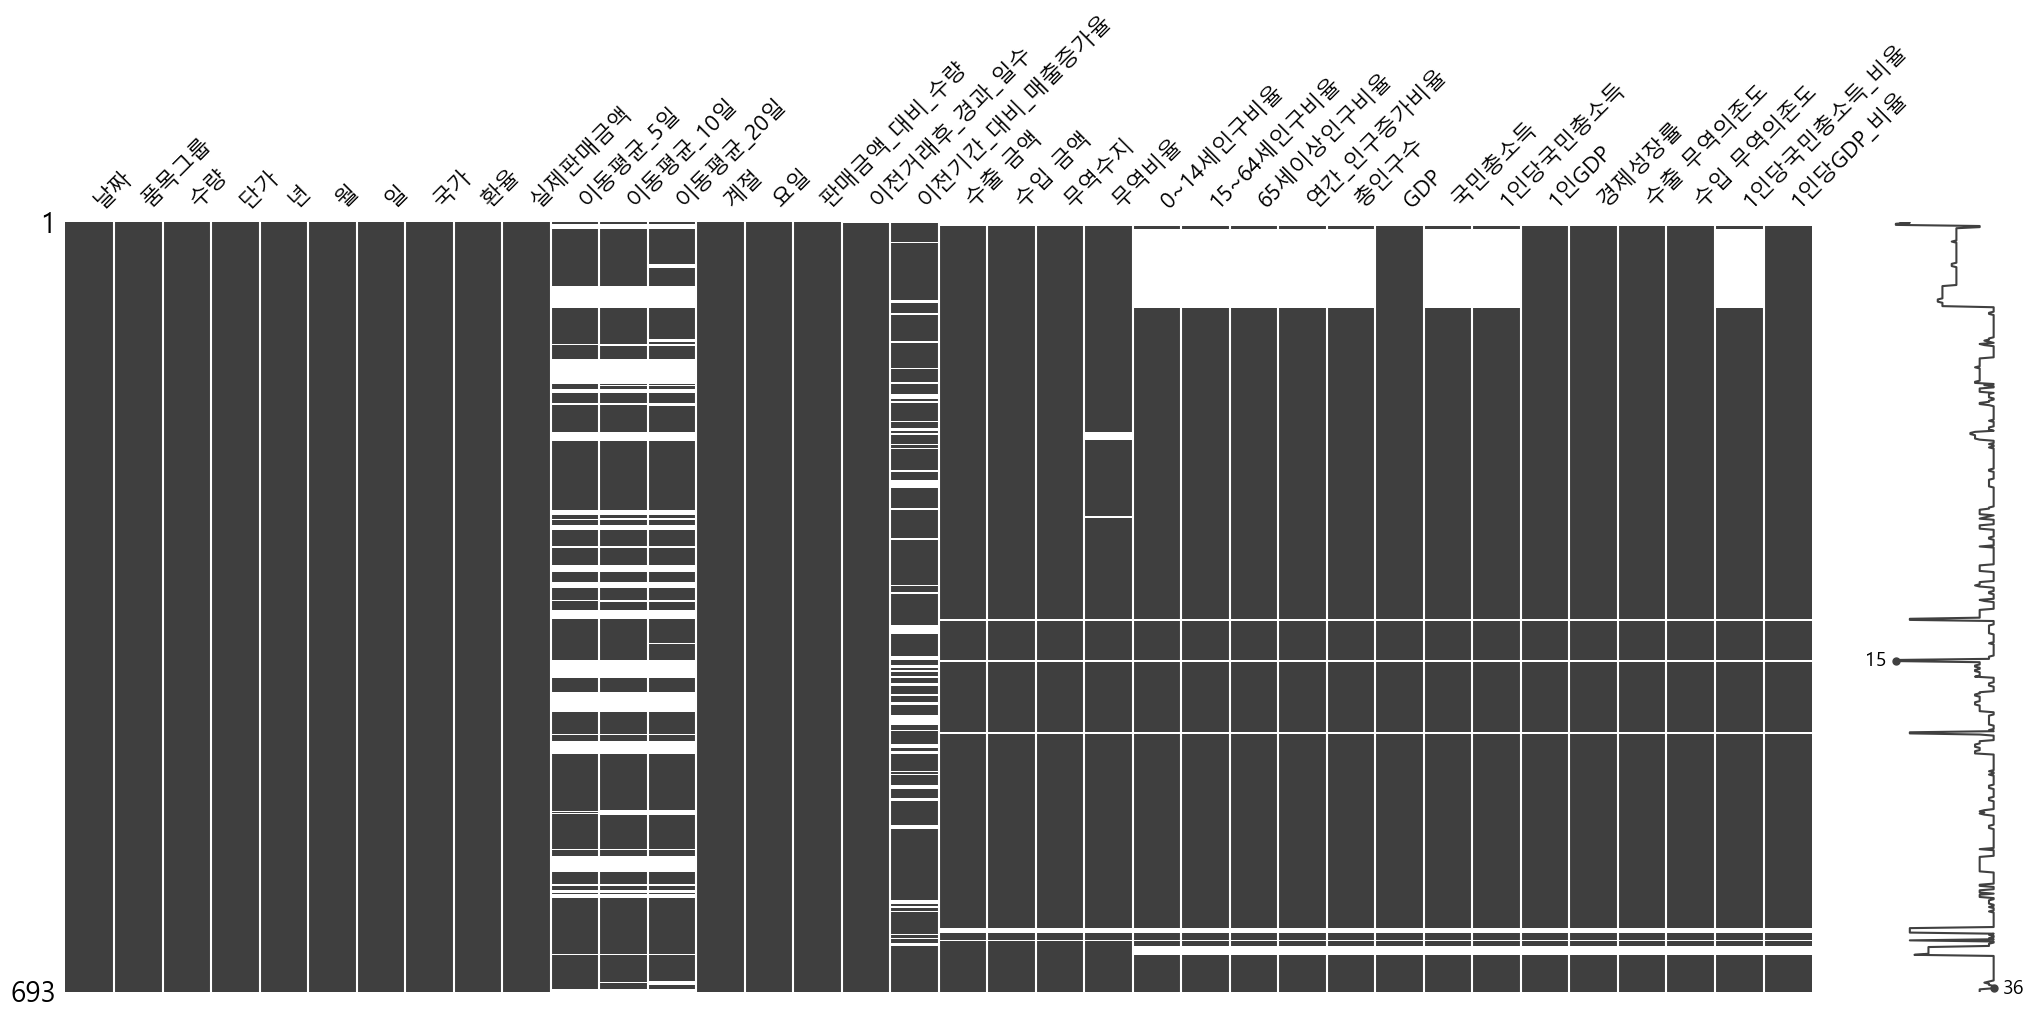

In [17]:
msno.matrix(data)

In [18]:
#이동평균, 이전 거래 기간 대비 매출 증가율은 0으로
zero = ['이동평균_5일', '이동평균_10일', '이동평균_20일', '이전기간_대비_매출증가율']
data[zero] = data[zero].fillna(0)

#다른 결측치는 제거 
remove = ['수출 금액', '수입 금액', '무역수지', '무역비율',
       '0~14세인구비율', '15~64세인구비율', '65세이상인구비율', '연간_인구증가비율', '총인구수', 'GDP',
       '국민총소득', '1인당국민총소득', '1인GDP', '경제성장률', '수출 무역의존도', '수입 무역의존도',
       '1인당국민총소득_비율', '1인당GDP_비율']
data = data.dropna(subset=remove)

<Axes: >

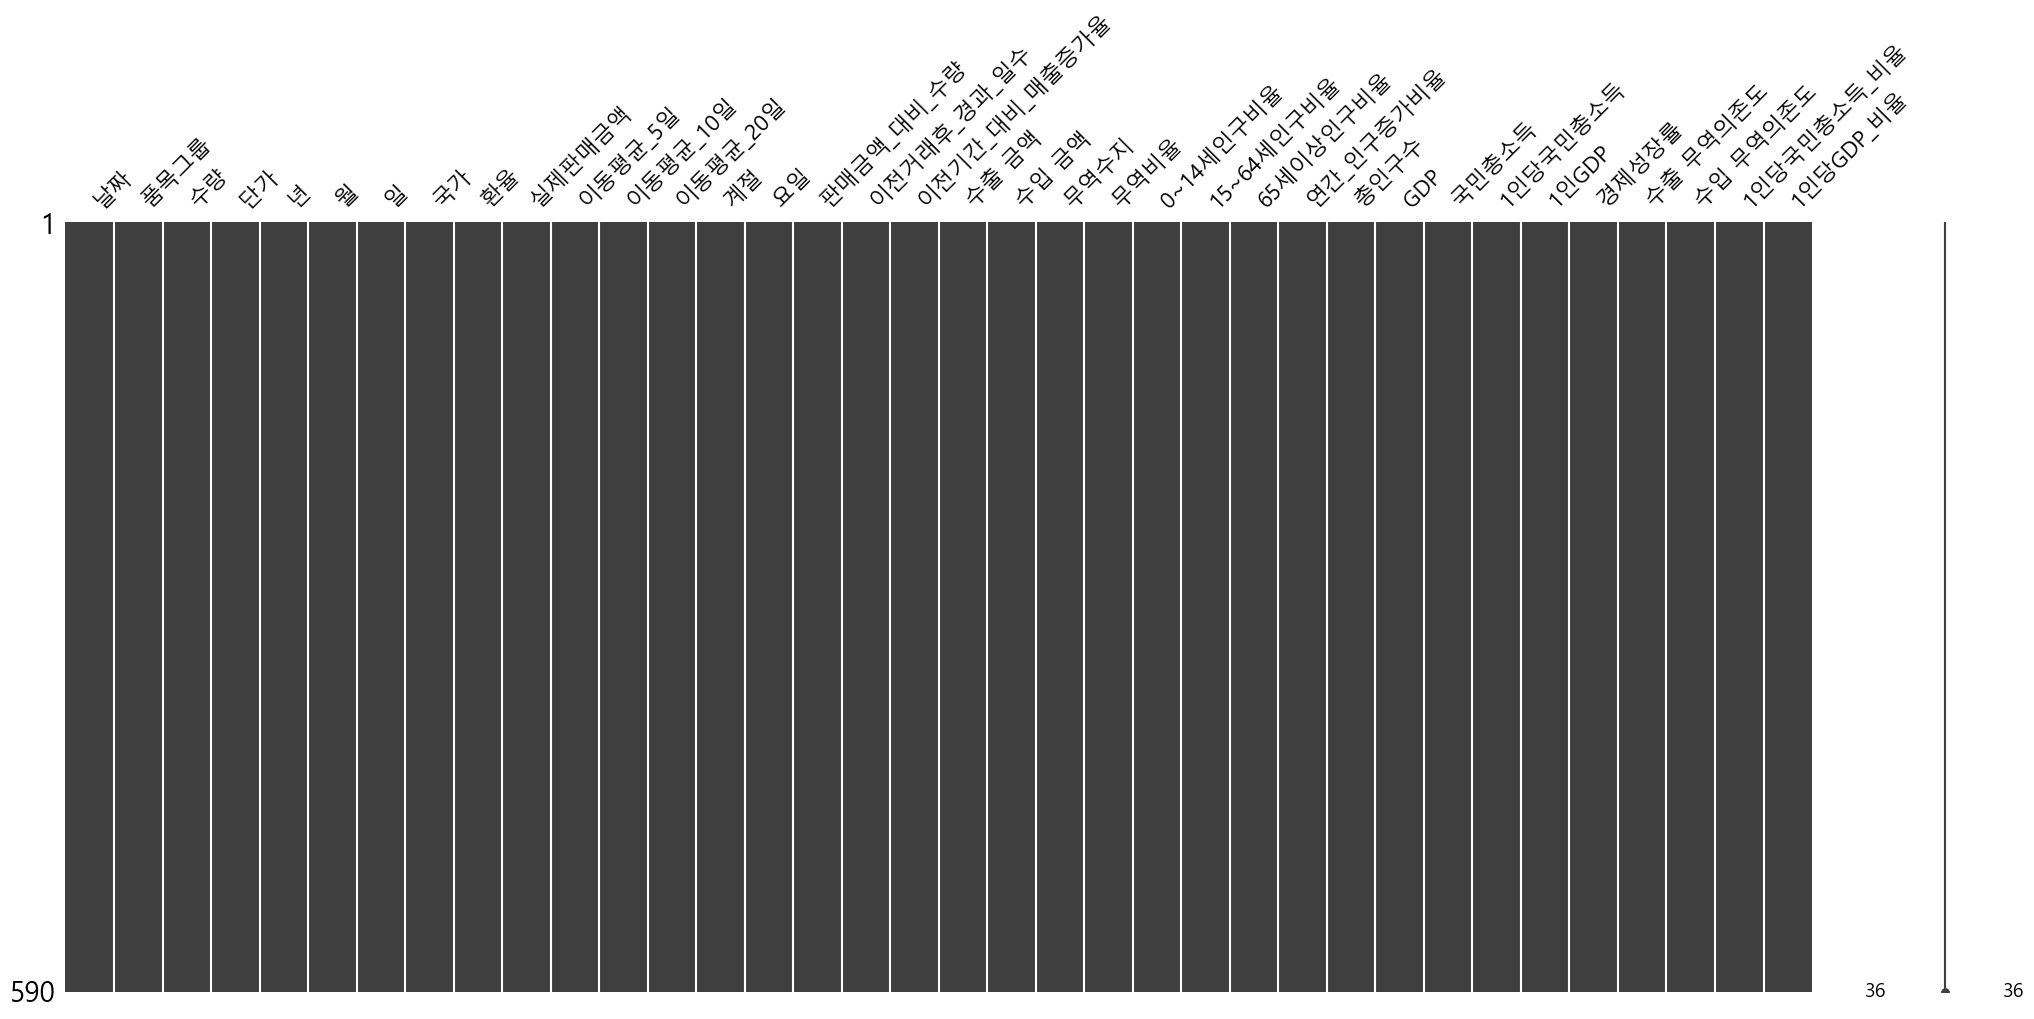

In [19]:
msno.matrix(data)

In [20]:
print(data['국가'].nunique())
print(data['국가'].unique())     #결측치 처리 후 27개국에 대해 분석 진행 

27
['네덜란드' '덴마크' '독일' '루마니아' '말레이시아' '멕시코' '베트남' '브라질' '스웨덴' '스위스' '슬로베니아'
 '싱가포르' '아르헨티나' '아일랜드' '영국' '오스트리아' '이스라엘' '인도' '인도네시아' '일본' '캐나다' '태국'
 '폴란드' '프랑스' '핀란드' '헝가리' '홍콩']


In [21]:
data.describe()

,수량,단가,년,월,일,환율,실제판매금액,이동평균_5일,이동평균_10일,이동평균_20일,...,연간_인구증가비율,총인구수,GDP,국민총소득,1인당국민총소득,1인GDP,수출 무역의존도,수입 무역의존도,1인당국민총소득_비율,1인당GDP_비율
count,590.000000,590.000000,590.0,590.000000,590.000000,590.000000,5.900000e+02,5.900000e+02,5.900000e+02,5.900000e+02,...,590.000000,5.900000e+02,5.900000e+02,5.900000e+02,590.000000,590.000000,5.900000e+02,5.900000e+02,5.900000e+02,5.900000e+02
mean,11.657627,1242.689831,2022.0,6.337288,15.286441,1005.001695,4.101412e+06,2.925441e+06,2.731550e+06,2.684347e+06,...,0.853837,1.445737e+08,1.639817e+12,1.844222e+12,38610.949153,36568.545763,1.830917e-06,2.849178e-06,6.190514e-08,6.190858e-08
std,23.791284,3139.048885,0.0,3.702860,8.455274,589.346767,9.184577e+06,1.372416e+07,9.328740e+06,6.901598e+06,...,0.659942,3.087008e+08,1.547151e+12,1.908416e+12,25945.590636,26046.157512,3.679073e-06,1.328364e-05,6.963686e-08,6.964097e-08
min,1.000000,0.000000,2022.0,1.000000,1.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.031000,2.108732e+06,6.210000e+10,6.452294e+10,2380.000000,2389.000000,0.000000e+00,0.000000e+00,7.062005e-10,7.057399e-10
25%,1.000000,0.000000,2022.0,3.000000,9.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.444000,8.769741e+06,4.088000e+11,3.993821e+11,8140.000000,8918.000000,1.991371e-07,0.000000e+00,7.992424e-09,7.992012e-09
50%,2.000000,200.000000,2022.0,6.000000,15.000000,1350.000000,6.750000e+05,0.000000e+00,0.000000e+00,0.000000e+00,...,0.735000,6.793566e+07,5.292000e+11,5.219463e+11,42440.000000,33815.000000,5.275224e-07,6.316775e-08,1.472080e-08,1.471990e-08
75%,10.000000,1171.500000,2022.0,9.000000,22.000000,1350.000000,3.375000e+06,5.252850e+05,1.258200e+06,1.754511e+06,...,0.908000,1.251250e+08,3.070700e+12,3.273921e+12,54650.000000,54660.000000,1.886895e-06,9.980431e-07,1.140262e-07,1.140287e-07
max,200.000000,40000.000000,2022.0,12.000000,31.000000,1425.000000,7.236000e+07,2.723954e+08,1.362460e+08,7.531204e+07,...,3.309000,1.417173e+09,4.231100e+12,5.310028e+12,89450.000000,104039.000000,1.941078e-05,1.149200e-04,4.742499e-07,4.743478e-07


## 상관관계 분석 

In [22]:
#시간요소 제거 
data['수량'] = pd.to_numeric(data['수량'], errors='coerce')
data['단가'] = pd.to_numeric(data['단가'], errors='coerce')
data['실제판매금액'] = pd.to_numeric(data['실제판매금액'], errors='coerce')
data['이동평균_5일'] = pd.to_numeric(data['이동평균_5일'], errors='coerce')
data['이동평균_10일'] = pd.to_numeric(data['이동평균_10일'], errors='coerce')
data['이동평균_20일'] = pd.to_numeric(data['이동평균_20일'], errors='coerce')
data['이전거래후_경과_일수'] = pd.to_numeric(data['이전거래후_경과_일수'], errors='coerce')
data['이전기간_대비_매출증가율'] = pd.to_numeric(data['이전기간_대비_매출증가율'], errors='coerce')
data['수출 금액'] = pd.to_numeric(data['수출 금액'], errors='coerce')
data['수입 금액'] = pd.to_numeric(data['수입 금액'], errors='coerce')
data['0~14세인구비율'] = pd.to_numeric(data['0~14세인구비율'], errors='coerce')
data['15~64세인구비율'] = pd.to_numeric(data['15~64세인구비율'], errors='coerce')
data['65세이상인구비율'] = pd.to_numeric(data['65세이상인구비율'], errors='coerce')
data['연간_인구증가비율'] = pd.to_numeric(data['연간_인구증가비율'], errors='coerce')
data['총인구수'] = pd.to_numeric(data['총인구수'], errors='coerce')
data['GDP'] = pd.to_numeric(data['GDP'], errors='coerce')
data['국민총소득'] = pd.to_numeric(data['국민총소득'], errors='coerce')
data['1인당국민총소득'] = pd.to_numeric(data['1인당국민총소득'], errors='coerce')
data['1인GDP'] = pd.to_numeric(data['1인GDP'], errors='coerce')
data['경제성장률'] = pd.to_numeric(data['경제성장률'], errors='coerce')

agg_functions = {
    '수량': 'sum',
    '단가': 'sum',
    '실제판매금액': 'sum',
    '이동평균_5일': 'sum',
    '이동평균_10일': 'sum',
    '이동평균_20일': 'sum',
    '이전거래후_경과_일수': 'mean',
    '이전기간_대비_매출증가율': 'mean',
    '수출 금액': 'sum',
    '수입 금액': 'sum',
    '0~14세인구비율': 'sum',
    '15~64세인구비율': 'sum',
    '65세이상인구비율': 'sum',
    '연간_인구증가비율': 'sum',
    '총인구수': 'sum',  
    'GDP': 'sum',  
    '국민총소득': 'sum',  
    '1인당국민총소득': 'sum',
    '1인GDP': 'sum',
    '경제성장률': 'mean'
}

grouped = data.groupby('국가').agg(agg_functions).reset_index()


In [23]:
#파생변수 다시 생성 
grouped['판매금액_대비_수량'] = grouped['수량'] / grouped['실제판매금액']
grouped['무역수지'] = grouped['수출 금액'] - grouped['수입 금액']
grouped['수출 무역의존도'] = grouped['수출 금액'] / grouped['GDP']
grouped['수입 무역의존도'] = grouped['수입 금액'] / grouped['GDP']
grouped['1인당국민총소득_비율'] = grouped['1인당국민총소득'] / grouped['국민총소득']
grouped['1인당GDP_비율'] = grouped['1인GDP'] / grouped['GDP']

In [24]:
grouped

,국가,수량,단가,실제판매금액,이동평균_5일,이동평균_10일,이동평균_20일,이전거래후_경과_일수,이전기간_대비_매출증가율,수출 금액,...,국민총소득,1인당국민총소득,1인GDP,경제성장률,판매금액_대비_수량,무역수지,수출 무역의존도,수입 무역의존도,1인당국민총소득_비율,1인당GDP_비율
0,네덜란드,3,8250,17820000,0.0,0.0,0.0,44.500000,0.546089,86000.0,...,2.033450e+12,114860.0,111970.0,4.5,1.683502e-07,64000.0,4.338614e-08,1.109878e-08,5.648528e-08,5.648774e-08
1,덴마크,725,63100,205343100,44480940.0,41113500.0,37060432.5,5.289855,inf,1098000.0,...,2.981636e+13,5050800.0,4621827.0,3.8,3.530676e-06,883000.0,4.024543e-08,7.880481e-09,1.693969e-07,1.694057e-07
2,독일,12,9157,15151050,42570900.0,21144510.0,26357197.5,62.500000,2.963556,695000.0,...,3.591193e+13,427120.0,387456.0,1.8,7.920243e-07,-21737000.0,2.133368e-08,6.885713e-07,1.189354e-08,1.189333e-08
3,루마니아,48,8274,28117800,0.0,0.0,655425.0,36.090909,inf,71000.0,...,3.264777e+12,172260.0,174812.0,4.8,1.707104e-06,71000.0,2.142232e-08,0.000000e+00,5.276317e-08,5.274477e-08
4,말레이시아,9,15800,21330000,165667410.0,132154605.0,66558037.5,35.125000,inf,185000.0,...,3.197846e+12,94240.0,95776.0,8.7,4.219409e-07,-29538000.0,5.691607e-08,9.144413e-06,2.946984e-08,2.946591e-08
5,멕시코,43,69555,179172000,214341660.0,114673590.0,65649960.0,18.411765,inf,500000.0,...,2.255911e+13,176970.0,188547.0,3.1,2.399929e-07,398000.0,2.079746e-08,4.242681e-09,7.844726e-09,7.842597e-09
6,베트남,565,82878,208219950,82246590.0,170194095.0,241773862.5,2.910448,inf,18333000.0,...,2.640690e+13,268670.0,278988.0,8.0,2.713477e-06,17608000.0,6.693416e-07,2.646990e-08,1.017423e-08,1.018591e-08
7,브라질,310,20042,144385200,44860770.0,26960715.0,21387037.5,24.000000,3.176662,423000.0,...,2.103826e+13,97680.0,107016.0,2.9,2.147034e-06,423000.0,1.835842e-08,0.000000e+00,4.642970e-09,4.644550e-09
8,스웨덴,5,3048,4166100,224370.0,2054160.0,17350335.0,83.250000,-0.582891,4000.0,...,2.642217e+12,251960.0,223492.0,2.6,1.200163e-06,-194000.0,1.706776e-09,8.448541e-08,9.535931e-08,9.536269e-08
9,스위스,1062,11905,41472000,17586720.0,78936255.0,52270785.0,33.333333,inf,166000.0,...,9.413623e+12,1073400.0,1105212.0,2.1,2.560764e-05,24000.0,1.712682e-08,1.465065e-08,1.140262e-07,1.140287e-07


In [25]:
grouped.to_csv('데이터/df_corr.csv', index=False)

In [26]:
grouped.isna().sum()

국가               0
수량               0
단가               0
실제판매금액           0
이동평균_5일          0
이동평균_10일         0
이동평균_20일         0
이전거래후_경과_일수      0
이전기간_대비_매출증가율    0
수출 금액            0
수입 금액            0
0~14세인구비율        0
15~64세인구비율       0
65세이상인구비율        0
연간_인구증가비율        0
총인구수             0
GDP              0
국민총소득            0
1인당국민총소득         0
1인GDP            0
경제성장률            0
판매금액_대비_수량       0
무역수지             0
수출 무역의존도         0
수입 무역의존도         0
1인당국민총소득_비율      0
1인당GDP_비율        0
dtype: int64

In [27]:
print(grouped['국가'].nunique())
print(grouped['국가'].unique())         #거래국가는 총 27개 국가

27
['네덜란드' '덴마크' '독일' '루마니아' '말레이시아' '멕시코' '베트남' '브라질' '스웨덴' '스위스' '슬로베니아'
 '싱가포르' '아르헨티나' '아일랜드' '영국' '오스트리아' '이스라엘' '인도' '인도네시아' '일본' '캐나다' '태국'
 '폴란드' '프랑스' '핀란드' '헝가리' '홍콩']


In [28]:
grouped.describe()

,수량,단가,실제판매금액,이동평균_5일,이동평균_10일,이동평균_20일,이전거래후_경과_일수,이전기간_대비_매출증가율,수출 금액,수입 금액,...,국민총소득,1인당국민총소득,1인GDP,경제성장률,판매금액_대비_수량,무역수지,수출 무역의존도,수입 무역의존도,1인당국민총소득_비율,1인당GDP_비율
count,27.000000,27.000000,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,27.000000,27.000000,2.700000e+01,2.700000e+01,...,2.700000e+01,2.700000e+01,2.700000e+01,27.000000,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01
mean,254.740741,27155.074074,8.962345e+07,6.392630e+07,5.968943e+07,5.865794e+07,41.990403,inf,3.170852e+06,9.957185e+06,...,4.029967e+13,8.437207e+05,7.990904e+05,4.225926,4.379384e-06,-6.786333e+06,1.106643e-07,4.156074e-07,8.017805e-08,8.018313e-08
std,325.386113,29813.186463,8.553434e+07,8.477188e+07,6.878610e+07,7.264858e+07,67.447516,NaN,6.558413e+06,3.268063e+07,...,1.074023e+14,1.296231e+06,1.152119e+06,2.841261,7.236429e-06,2.921449e+07,1.609276e-07,1.754486e-06,1.012876e-07,1.013046e-07
min,1.000000,1320.000000,2.295000e+06,0.000000e+00,0.000000e+00,0.000000e+00,2.910448,-0.582891,2.000000e+03,0.000000e+00,...,6.452294e+10,3.060000e+04,2.945700e+04,-3.500000,6.668534e-08,-1.389520e+08,1.706776e-09,0.000000e+00,7.062005e-10,7.057399e-10
25%,13.500000,5434.500000,1.937588e+07,3.028590e+06,5.205532e+06,7.755017e+06,11.017094,1.956711,1.755000e+05,4.000000e+03,...,2.999448e+12,1.062700e+05,1.094930e+05,2.600000,4.561547e-07,1.300000e+04,2.106557e-08,1.367473e-09,1.291620e-08,1.292122e-08
50%,92.000000,11905.000000,5.103000e+07,2.632608e+07,2.422764e+07,2.659756e+07,24.200000,NaN,4.600000e+05,2.030000e+05,...,9.413623e+12,2.519600e+05,2.234920e+05,4.100000,1.337681e-06,2.210000e+05,5.101124e-08,8.640238e-09,2.946984e-08,2.946591e-08
75%,306.000000,48717.500000,1.482489e+08,8.302300e+07,8.940012e+07,6.403036e+07,43.095238,NaN,1.734500e+06,3.910000e+05,...,2.830956e+13,8.809400e+05,9.143365e+05,5.250000,3.301242e-06,1.035000e+06,1.236502e-07,3.850151e-08,1.123090e-07,1.123082e-07
max,1062.000000,94474.000000,3.117285e+08,3.214234e+08,2.219033e+08,2.417739e+08,356.000000,inf,2.411700e+07,1.630690e+08,...,5.628630e+14,5.050800e+06,4.621827e+06,12.000000,2.560764e-05,2.000500e+07,6.693416e-07,9.144413e-06,4.742499e-07,4.743478e-07


In [29]:
df_corr = grouped[['수량', '단가', '이동평균_5일', '이동평균_10일', '이동평균_20일',
       '이전거래후_경과_일수', '이전기간_대비_매출증가율', '수출 금액', '수입 금액', '0~14세인구비율',
       '15~64세인구비율', '65세이상인구비율', '연간_인구증가비율', '총인구수', 'GDP', '국민총소득',
       '1인당국민총소득', '1인GDP', '경제성장률', '판매금액_대비_수량', '무역수지', '수출 무역의존도',
       '수입 무역의존도', '1인당국민총소득_비율', '1인당GDP_비율', '실제판매금액']]
df_corr.head()

,수량,단가,이동평균_5일,이동평균_10일,이동평균_20일,이전거래후_경과_일수,이전기간_대비_매출증가율,수출 금액,수입 금액,0~14세인구비율,...,1인당국민총소득,1인GDP,경제성장률,판매금액_대비_수량,무역수지,수출 무역의존도,수입 무역의존도,1인당국민총소득_비율,1인당GDP_비율,실제판매금액
0,3,8250,0.0,0.0,0.0,44.500000,0.546089,86000.0,22000.0,30.850,...,114860.0,111970.0,4.5,1.683502e-07,64000.0,4.338614e-08,1.109878e-08,5.648528e-08,5.648774e-08,17820000
1,725,63100,44480940.0,41113500.0,37060432.5,5.289855,inf,1098000.0,215000.0,1108.140,...,5050800.0,4621827.0,3.8,3.530676e-06,883000.0,4.024543e-08,7.880481e-09,1.693969e-07,1.694057e-07,205343100
2,12,9157,42570900.0,21144510.0,26357197.5,62.500000,2.963556,695000.0,22432000.0,111.664,...,427120.0,387456.0,1.8,7.920243e-07,-21737000.0,2.133368e-08,6.885713e-07,1.189354e-08,1.189333e-08,15151050
3,48,8274,0.0,0.0,655425.0,36.090909,inf,71000.0,0.0,175.109,...,172260.0,174812.0,4.8,1.707104e-06,71000.0,2.142232e-08,0.000000e+00,5.276317e-08,5.274477e-08,28117800
4,9,15800,165667410.0,132154605.0,66558037.5,35.125000,inf,185000.0,29723000.0,181.384,...,94240.0,95776.0,8.7,4.219409e-07,-29538000.0,5.691607e-08,9.144413e-06,2.946984e-08,2.946591e-08,21330000


#### 정규성 검정 
- Shapiro Wilks test: 표본수가 2000미만인 데이터셋에 적합한 정규성 검정 
- https://bioinformaticsandme.tistory.com/37

In [30]:
from scipy.stats import shapiro

# 정규성 검정을 수행할 변수들 선택
columns = ['수량', '단가', '이동평균_5일', '이동평균_10일', '이동평균_20일',
       '이전거래후_경과_일수', '이전기간_대비_매출증가율', '수출 금액', '수입 금액', '0~14세인구비율',
       '15~64세인구비율', '65세이상인구비율', '연간_인구증가비율', '총인구수', 'GDP', '국민총소득',
       '1인당국민총소득', '1인GDP', '경제성장률', '판매금액_대비_수량', '무역수지', '수출 무역의존도',
       '수입 무역의존도', '1인당국민총소득_비율', '1인당GDP_비율', '실제판매금액']

# 각 변수에 대해 정규성 검정 수행
for column in columns:
    sample = df_corr[column]
    stat, p_value = shapiro(sample)
    
    print(f'{column}:')
    print(f'Statistic: {stat}, p-value: {p_value}')
    
    if p_value > 0.05:
        print('데이터는 정규 분포를 따릅니다.\n')
    else:
        print('데이터는 정규 분포를 따르지 않습니다.\n')


수량:
Statistic: 0.7688348889350891, p-value: 4.135001290705986e-05
데이터는 정규 분포를 따르지 않습니다.

단가:
Statistic: 0.7916364669799805, p-value: 9.838928235694766e-05
데이터는 정규 분포를 따르지 않습니다.

이동평균_5일:
Statistic: 0.7653893232345581, p-value: 3.6417484807316214e-05
데이터는 정규 분포를 따르지 않습니다.

이동평균_10일:
Statistic: 0.8186440467834473, p-value: 0.000293065735604614
데이터는 정규 분포를 따르지 않습니다.

이동평균_20일:
Statistic: 0.7552652359008789, p-value: 2.5216239009751007e-05
데이터는 정규 분포를 따르지 않습니다.

이전거래후_경과_일수:
Statistic: 0.5038312673568726, p-value: 1.8418774061501608e-08
데이터는 정규 분포를 따르지 않습니다.

이전기간_대비_매출증가율:
Statistic: nan, p-value: 1.0
데이터는 정규 분포를 따릅니다.

수출 금액:
Statistic: 0.5189563035964966, p-value: 2.6374609163326568e-08
데이터는 정규 분포를 따르지 않습니다.

수입 금액:
Statistic: 0.3477209210395813, p-value: 6.503562133275409e-10
데이터는 정규 분포를 따르지 않습니다.

0~14세인구비율:
Statistic: 0.7534806728363037, p-value: 2.3654552933294326e-05
데이터는 정규 분포를 따르지 않습니다.

15~64세인구비율:
Statistic: 0.7646646499633789, p-value: 3.5461969673633575e-05
데이터는 정규 분포를 따르지 않습

<Axes: >

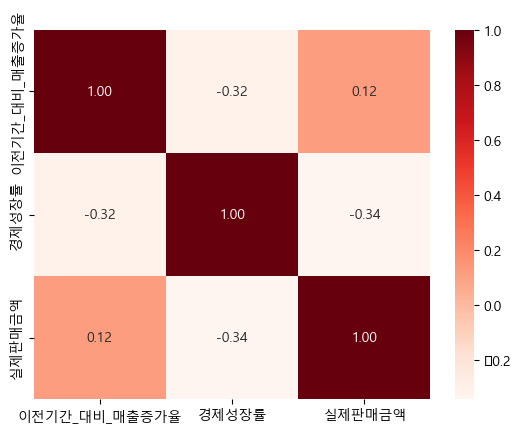

In [31]:
#pearson: 정규분포 따름 
pearson = grouped[['이전기간_대비_매출증가율', '경제성장률', '실제판매금액']]
sns.heatmap(data = pearson.corr(), annot=True, fmt = '.2f', cmap='Reds')

Spearman vs Kendall
- 대부분의 상황에서 Kendall's Tau와 Spearman의 순위 상관 계수의 해석은 매우 유의하고, 비슷한 추론으로 이어지니 개인의 데이터 수를 고려하여 진행
- https://ina-study.tistory.com/7

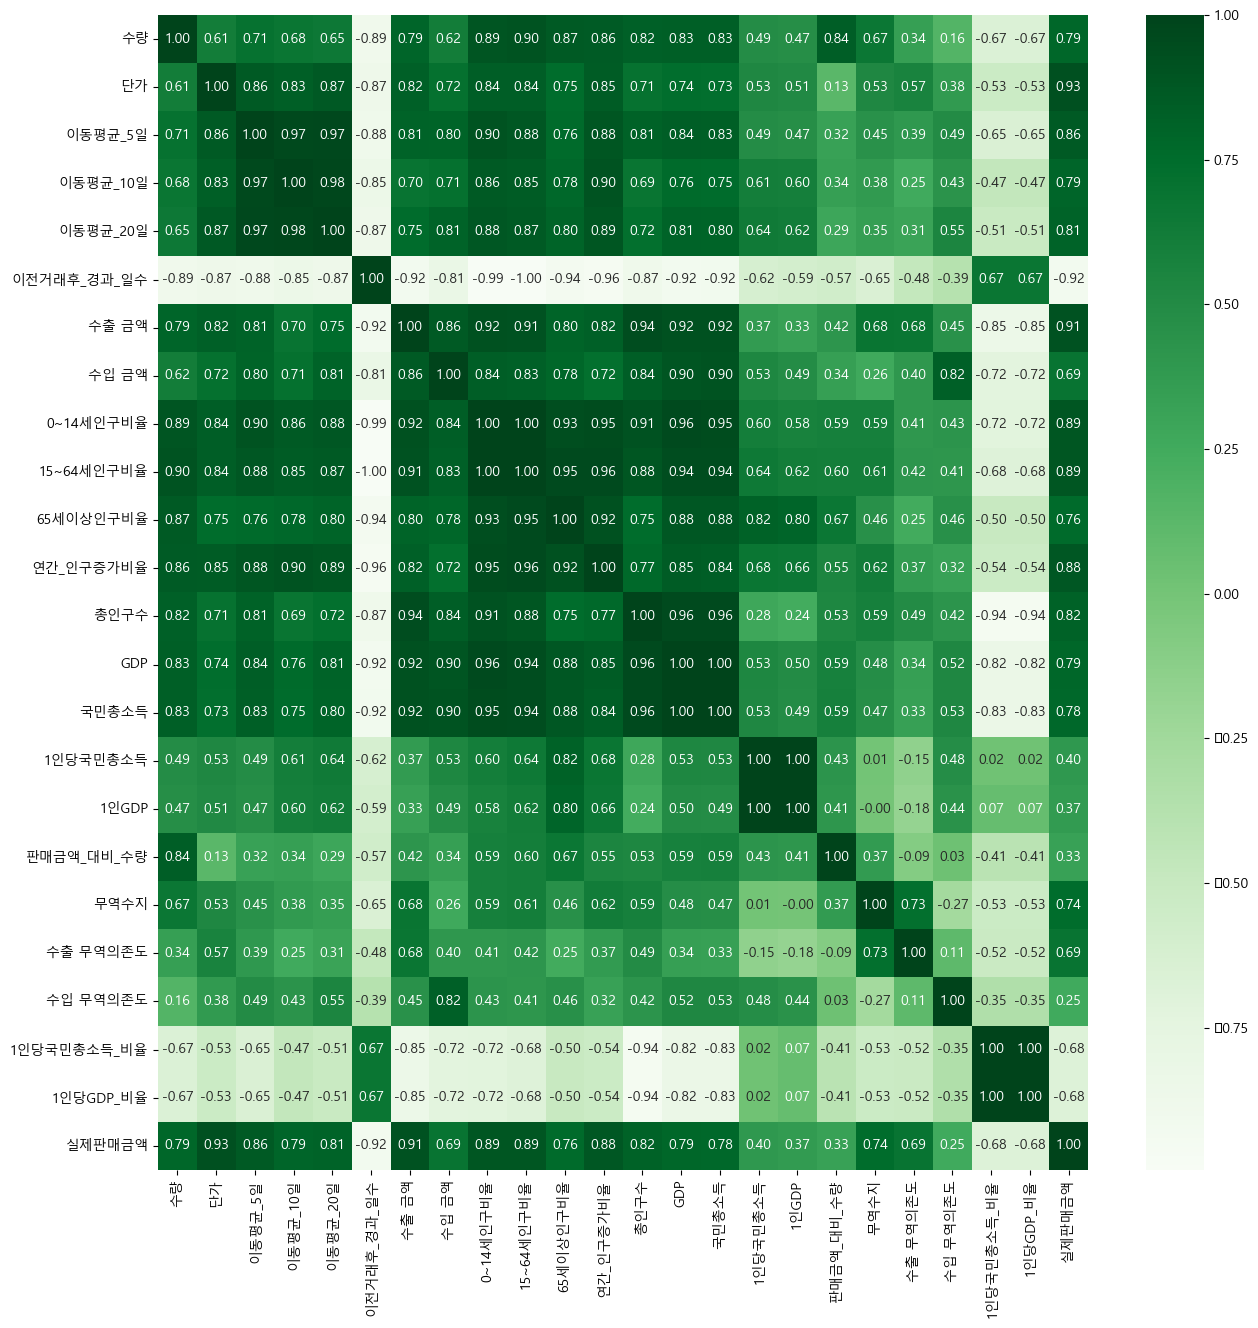

In [32]:
#spearman: 정규분포 따르지 않음 
nonnormal = grouped[['수량', '단가', '이동평균_5일', '이동평균_10일', '이동평균_20일',
       '이전거래후_경과_일수', '수출 금액', '수입 금액', '0~14세인구비율',
       '15~64세인구비율', '65세이상인구비율', '연간_인구증가비율', '총인구수', 'GDP', '국민총소득',
       '1인당국민총소득', '1인GDP', '판매금액_대비_수량', '무역수지', '수출 무역의존도',
       '수입 무역의존도', '1인당국민총소득_비율', '1인당GDP_비율', '실제판매금액']]
df_corr_spearman = nonnormal.corr(method='spearman')
plt.figure(figsize=(15, 15))
sns.heatmap(data = df_corr_spearman.corr(), annot=True, fmt = '.2f', cmap='Greens')
plt.show()

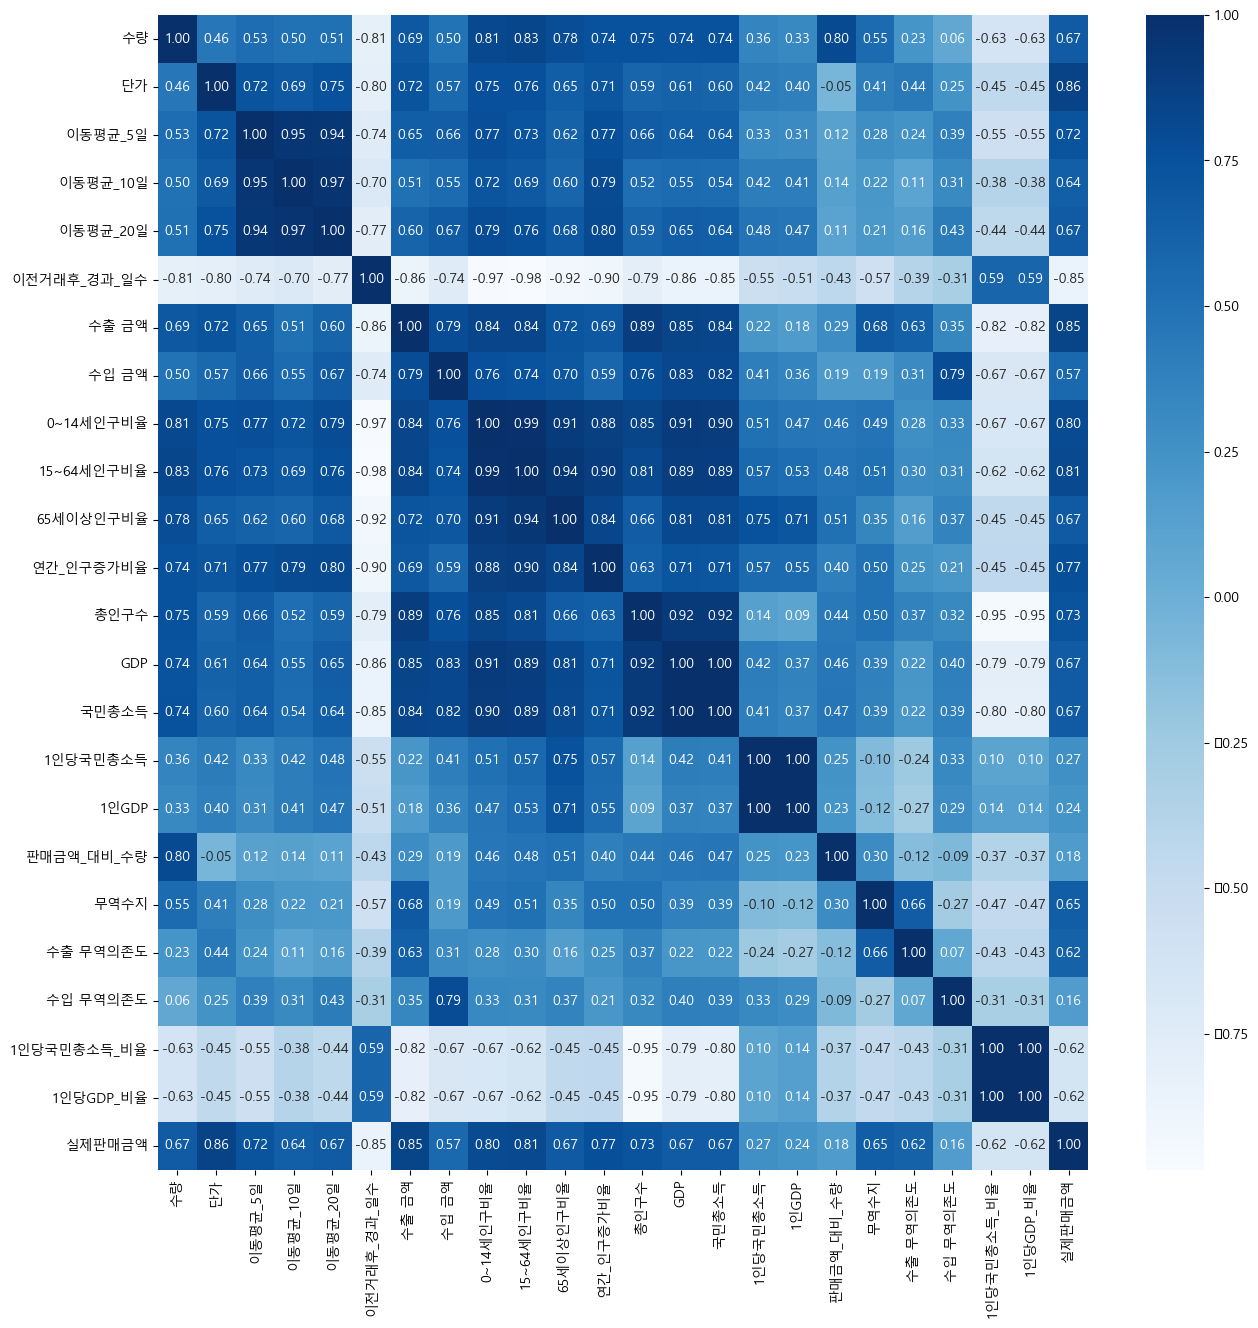

In [33]:
#kendall: 정규분포 따르지 않고 표본수가 30보다 적음 
df_corr_kendall = nonnormal.corr(method='kendall')
plt.figure(figsize=(15, 15))
sns.heatmap(data = df_corr_kendall.corr(), annot=True, fmt = '.2f', cmap='Blues')
plt.show()

상관계수 0.7 이상 = 강한 상관관계, 0.3 ~ 0.7 = 보통의 상관관계
- 강한 상관관계: 단가(0.86), 이동평균_5일(0.72), 수출 금액(0.85), 0~14세 인구비율(0.80), 15~64세 인구비율(0.81), 연간 인구 증가비율(0.77), 총인구수(0.73)
- 보통의 상관관계: 수량(0.67), 이동평균_10일(0.64), 이동평균_20일(0.67), 수입 금액(0.57), 65세상 인구비율(0.67), GDP(0.67), 무역수지(0.65), 수출 무역의존도(0.62)

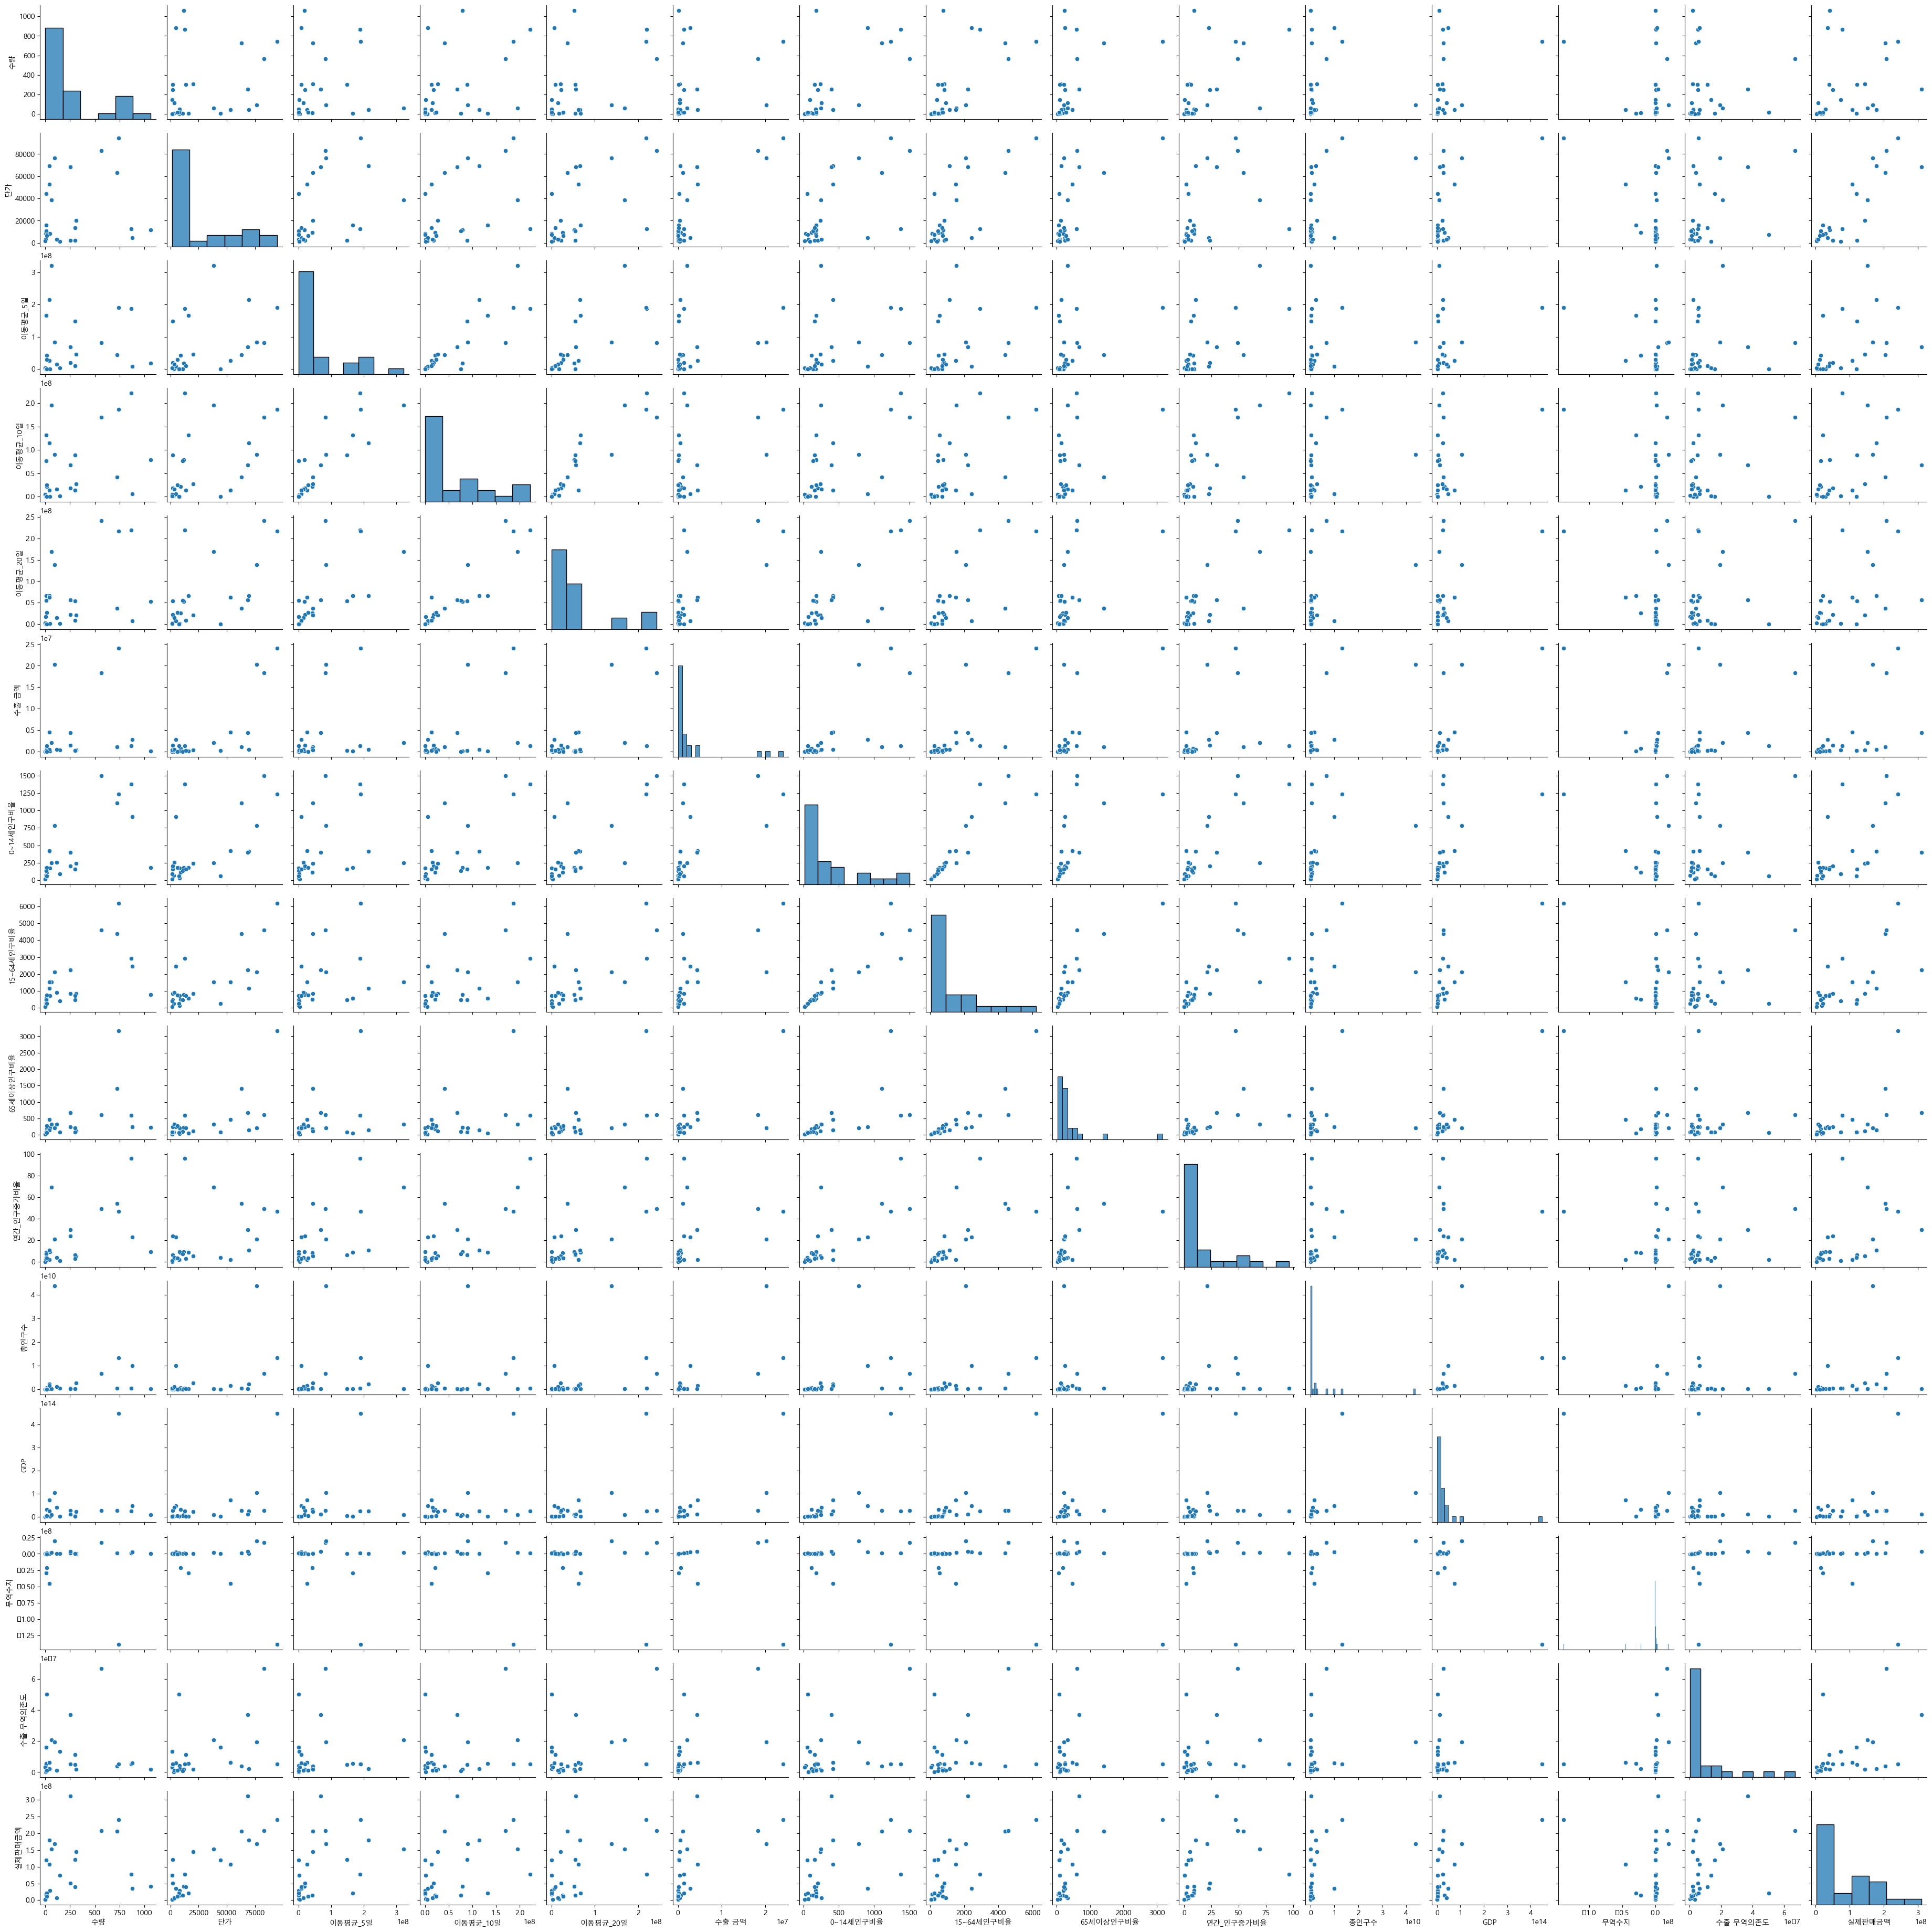

In [34]:
df_scatter = grouped[['수량', '단가', '이동평균_5일', '이동평균_10일', '이동평균_20일', '수출 금액', '0~14세인구비율',
       '15~64세인구비율', '65세이상인구비율', '연간_인구증가비율', '총인구수', 'GDP', '무역수지', '수출 무역의존도', '실제판매금액']]
sns.pairplot(df_scatter)
plt.show()

In [35]:
#상관관계 유의성 검정 
from scipy.stats import kendalltau

for column in nonnormal.columns:
    if column != '실제판매금액':
        tau, p_value = kendalltau(nonnormal['실제판매금액'], nonnormal[column])
        print(f"변수 '{column}':")
        print(f"Kendall's Tau: {tau}")
        print(f"P-value: {p_value}")
        if p_value < 0.05:
            print("결과: 통계적으로 유의미한 상관관계가 있음\n")
        else:
            print("결과: 통계적으로 유의미한 상관관계가 없음\n")


변수 '수량':
Kendall's Tau: 0.4051359329103309
P-value: 0.0030673685614715416
결과: 통계적으로 유의미한 상관관계가 있음

변수 '단가':
Kendall's Tau: 0.5726495726495727
P-value: 1.0013722789065318e-05
결과: 통계적으로 유의미한 상관관계가 있음

변수 '이동평균_5일':
Kendall's Tau: 0.44224271043563135
P-value: 0.0013686041091947481
결과: 통계적으로 유의미한 상관관계가 있음

변수 '이동평균_10일':
Kendall's Tau: 0.37645077008141775
P-value: 0.006217160006184179
결과: 통계적으로 유의미한 상관관계가 있음

변수 '이동평균_20일':
Kendall's Tau: 0.37660523340960333
P-value: 0.0059161970162774115
결과: 통계적으로 유의미한 상관관계가 있음

변수 '이전거래후_경과_일수':
Kendall's Tau: -0.5327635327635328
P-value: 4.81636777621839e-05
결과: 통계적으로 유의미한 상관관계가 있음

변수 '수출 금액':
Kendall's Tau: 0.5534955703141141
P-value: 5.228301906630753e-05
결과: 통계적으로 유의미한 상관관계가 있음

변수 '수입 금액':
Kendall's Tau: 0.24424550797610683
P-value: 0.08053429471648832
결과: 통계적으로 유의미한 상관관계가 없음

변수 '0~14세인구비율':
Kendall's Tau: 0.47008547008547014
P-value: 0.0004107263685135341
결과: 통계적으로 유의미한 상관관계가 있음

변수 '15~64세인구비율':
Kendall's Tau: 0.5327635327635328
P-value: 4.81636

상관관계 유의하지 않은 것들: `수입 금액`, `1인당국민총소득`, `1인GDP`, `판매금액 대비 수량`, `수입 무역의존도`, `1인당국민총소득 비율`, `1인당GDP 비율`

## 군집분석 (준비단계)

#### 군집분석에 사용할 변수 선택

- 주성분분석: 목표변수를 고려하여 목표변수를 잘 예측/분류할 수 있는 선형 결합으로 이루어진 몇 개의 주성분을 찾아냄
- 요인분석: 목표변수를 고려하지 않고 주어진 데이터들 간의 상관성을 토대로 비슷한 변수들을 묶어서 새로운 잠재변수를 만들어 냄 
- https://m.blog.naver.com/0325han/221325610612

In [36]:
df_ca = grouped[['국가', '수량', '단가', '이동평균_5일', '이동평균_10일', '이동평균_20일',
       '이전거래후_경과_일수', '이전기간_대비_매출증가율', '수출 금액', '수입 금액', '0~14세인구비율',
       '15~64세인구비율', '65세이상인구비율', '연간_인구증가비율', '총인구수', 'GDP', '국민총소득',
       '1인당국민총소득', '1인GDP', '경제성장률', '판매금액_대비_수량', '무역수지', '수출 무역의존도',
       '수입 무역의존도', '1인당국민총소득_비율', '1인당GDP_비율', '실제판매금액']]

In [37]:
#inf 0으로 대체하기 
df_ca.replace([float('inf'), float('-inf')], 0, inplace=True)

In [38]:
#다중공선성 
from statsmodels.stats.outliers_influence import variance_inflation_factor

df_vif = df_ca[['수량', '단가', '이동평균_5일', '이동평균_10일', '이동평균_20일',
       '이전거래후_경과_일수', '이전기간_대비_매출증가율', '수출 금액', '수입 금액', '0~14세인구비율',
       '15~64세인구비율', '65세이상인구비율', '연간_인구증가비율', '총인구수', 'GDP', '국민총소득',
       '1인당국민총소득', '1인GDP', '경제성장률', '판매금액_대비_수량', '무역수지', '수출 무역의존도',
       '수입 무역의존도', '1인당국민총소득_비율', '1인당GDP_비율', '실제판매금액']]

columns = ['수량', '단가', '이동평균_5일', '이동평균_10일', '이동평균_20일',
       '이전거래후_경과_일수', '이전기간_대비_매출증가율', '수출 금액', '수입 금액', '0~14세인구비율',
       '15~64세인구비율', '65세이상인구비율', '연간_인구증가비율', '총인구수', 'GDP', '국민총소득',
       '1인당국민총소득', '1인GDP', '경제성장률', '판매금액_대비_수량', '무역수지', '수출 무역의존도',
       '수입 무역의존도', '1인당국민총소득_비율', '1인당GDP_비율', '실제판매금액']

vif_data = pd.DataFrame()
vif_data["feature"] = columns
vif_data["VIF"] = [variance_inflation_factor(df_vif, i) for i in range(df_vif.shape[1])]

print(vif_data)

          feature          VIF
0              수량     5.311432
1              단가    15.085874
2         이동평균_5일    18.934602
3        이동평균_10일    70.810359
4        이동평균_20일   179.187411
5     이전거래후_경과_일수     1.510863
6   이전기간_대비_매출증가율     1.241071
7           수출 금액          inf
8           수입 금액          inf
9       0~14세인구비율   277.082985
10     15~64세인구비율   634.617685
11      65세이상인구비율   918.972457
12      연간_인구증가비율    26.225481
13           총인구수    30.765842
14            GDP  4773.900096
15          국민총소득  5850.109781
16       1인당국민총소득  4203.867144
17          1인GDP  3428.740224
18          경제성장률     3.326505
19     판매금액_대비_수량     7.072883
20           무역수지          inf
21       수출 무역의존도     4.181138
22       수입 무역의존도    14.521601
23    1인당국민총소득_비율    15.728257
24      1인당GDP_비율    15.725562
25         실제판매금액    11.512479


- VIF 10 이하: `수량`, `이전 거래 후 경과 일수`, `이전기간 대비 매출 증가율`, `경제성장률`, `판매금액 대비 수량`, `수출 무역의존도`
- VIF 10 이상 15 이하: `수입 무역의존도`, `실제판매금액` 

In [39]:
#위 변수들만 을 남기기 
df_ca = df_ca[['수량', '이전거래후_경과_일수', '이전기간_대비_매출증가율', '경제성장률', '판매금액_대비_수량', '수출 무역의존도', '수입 무역의존도', '실제판매금액']]

요인성 평가: 요인분석을 수행하기 전에 데이터 세트의 요인성을 평가. 이는 데이터 세트에서 요인을 찾을 수 있는지를 확인. 인수 분해성 또는 샘플링 적절성을 확인하는 방법
- Bartlett Test: p-value로 평가 
- Kaiser-Meyer-Olkin (KMO) 검정: 모든 변수 간의 분산 비율을 추정하며, 0.6 미만이면 부적절하며 0.8 이상이면 우수하다고 판단 

In [40]:
#Bartlett
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_sq_value, p_value = calculate_bartlett_sphericity(df_ca)
chi_sq_value, p_value

#귀무가설 (H0): 모든 변수들 간의 상관관계가 0이다. 즉, 공분산 행렬은 단위행렬이다.
#대립가설 (H1): 적어도 하나의 변수 쌍 사이에는 상관관계가 있다. 공분산 행렬이 단위행렬이 아니다.
#p-value가 일반적으로 설정한 유의수준 (예: 0.05)보다 작으면 귀무가설을 기각하고 대립가설을 채택

#p-value가 0.05보다 작기 때문에 귀무가설 기각 -> 적어도 하나의 변수 쌍 사이에 상관관계 있다. 

(51.31098952337379, 0.004600994875129965)

In [41]:
#KMO 검정 
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all, kmo_model = calculate_kmo(df_ca)
kmo_model
#값이 0.6보다 작기 때문에 데이터는 요인분석에 적합한 데이터가 아닐 가능성이 높음 

0.12503089430458825

요인분석 진행 x

In [42]:
from sklearn.preprocessing import StandardScaler
columns = ['수량', '이전거래후_경과_일수', '이전기간_대비_매출증가율', '경제성장률', '판매금액_대비_수량', '수출 무역의존도', '수입 무역의존도', '실제판매금액']

x = df_ca.loc[:, columns].values
y = df_ca.loc[:, ['실제판매금액']].values

scaler = StandardScaler()
x_sc = scaler.fit_transform(x)

In [43]:
from factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer(n_factors=5, rotation='varimax')
fa.fit(x_sc)

# 고유값 확인
eigenvalues = fa.get_eigenvalues()
eigenvalues
#첫 세트: 고유값, 두번째 세트: 누적된 고유값 

(array([2.06431468, 1.67423148, 1.26012312, 0.99280588, 0.85248457,
        0.6182271 , 0.43457871, 0.10323447]),
 array([ 1.83363167e+00,  1.53991579e+00,  1.11053144e+00,  7.90279458e-01,
         2.64277855e-01,  2.84913235e-02,  1.08813003e-03, -3.92695306e-02]))

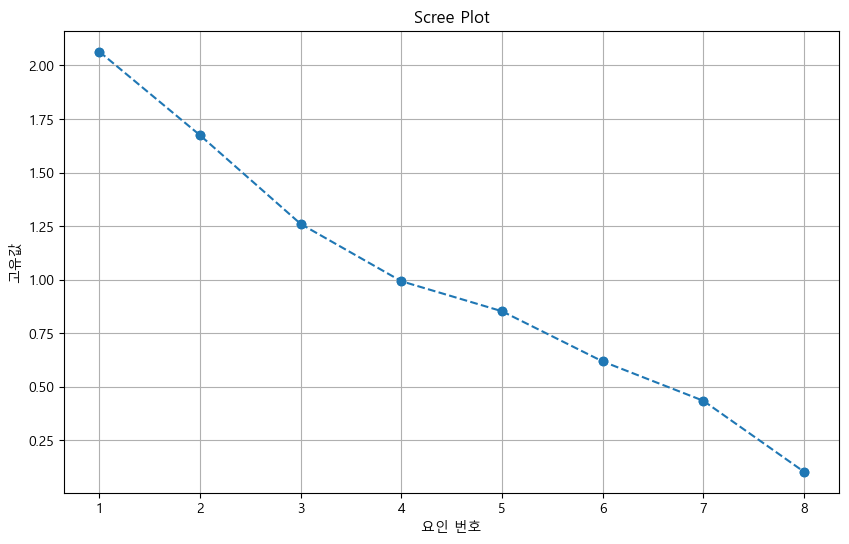

In [44]:
# 고유값
eigenvalues = [2.06431468, 1.67423148, 1.26012312, 0.99280588, 0.85248457,
        0.6182271 , 0.43457871, 0.10323447]

# Scree Plot 그리기
plt.figure(figsize=(10, 6))
plt.scatter(range(1, len(eigenvalues)+1), eigenvalues)
plt.plot(range(1, len(eigenvalues)+1), eigenvalues, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('요인 번호')
plt.ylabel('고유값')
plt.grid(True)
plt.show()

In [45]:
#변수 선택
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

selected_features = ['수량', '이동평균_5일', '이전거래후_경과_일수', '이전기간_대비_매출증가율', '총인구수', '경제성장률', '판매금액_대비_수량', '수출 무역의존도', '수입 무역의존도', '1인당GDP_비율']  # 선택한 변수들의 리스트
target = '실제판매금액'  # 타겟 변수

# 최적의 모델 초기화
best_model = None
best_subset = None
best_mse = float('inf')

# 변수의 모든 가능한 조합을 생성하고 평가
for k in range(1, len(selected_features) + 1):
    for subset in combinations(selected_features, k):
        subset = list(subset)
        X_subset = grouped[subset]
        y = grouped[target]
        model = LinearRegression()
        model.fit(X_subset, y)
        y_pred = model.predict(X_subset)
        mse = mean_squared_error(y, y_pred)
        
        if mse < best_mse:
            best_mse = mse
            best_model = model
            best_subset = subset

print("Best Subset:", best_subset)
print("Best MSE:", best_mse)


ValueError: Input X contains infinity or a value too large for dtype('float64').

In [46]:
#위 변수를 가지고 클러스터링용 데이터셋 구축 (거래국가 + 비거래국가)
df_clus = pd.merge(df1, df2, on=['국가', '년', '월'], how='left')
df_clus = df_clus.sort_values(by=['국가', '년', '월', '일'])
df_clus

,년,월,국가,수출 금액,수입 금액,무역수지,무역비율,0~14세인구비율,15~64세인구비율,65세이상인구비율,...,환율,실제판매금액,이동평균_5일,이동평균_10일,이동평균_20일,계절,요일,판매금액_대비_수량,이전거래후_경과_일수,이전기간_대비_매출증가율
0,2022,3,괌,0,0,0,NaN,26.053,62.106,11.841,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022,12,나이지리아,5000,0,5000,inf,43.045,53.981,2.974,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022,10,남아프리카공화국,3000,0,3000,inf,28.551,65.556,5.893,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2022,1,네덜란드,2000,8000,-6000,0.250000,15.425,64.260,20.315,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2022,2,네덜란드,0,1000,-1000,0.000000,15.425,64.260,20.315,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,2022,9,홍콩,50000,1000,49000,50.000000,12.041,67.487,20.473,...,1350.0,3037500.0,0.0,0.0,0.0,가을,Friday,0.000005,8.0,-0.806867
900,2022,10,홍콩,45000,0,45000,inf,12.041,67.487,20.473,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
890,2022,11,홍콩,18000,0,18000,inf,12.041,67.487,20.473,...,1350.0,1080000.0,NaN,NaN,NaN,가을,Thursday,0.000002,26.0,inf
891,2022,11,홍콩,18000,0,18000,inf,12.041,67.487,20.473,...,1350.0,1822500.0,NaN,NaN,NaN,가을,Friday,0.000005,1.0,0.687500


In [47]:
df_clus = df_clus[['국가', '수량', '이전거래후_경과_일수', '이전기간_대비_매출증가율', '경제성장률', '판매금액_대비_수량', '수출 무역의존도', '수입 무역의존도', '실제판매금액', 'GDP', '수출 금액', '수입 금액']]

In [48]:
df_clus.isna().sum()

국가                 0
수량               247
이전거래후_경과_일수      247
이전기간_대비_매출증가율    350
경제성장률             20
판매금액_대비_수량       247
수출 무역의존도          21
수입 무역의존도          21
실제판매금액           247
GDP               20
수출 금액              0
수입 금액              0
dtype: int64

<Axes: >

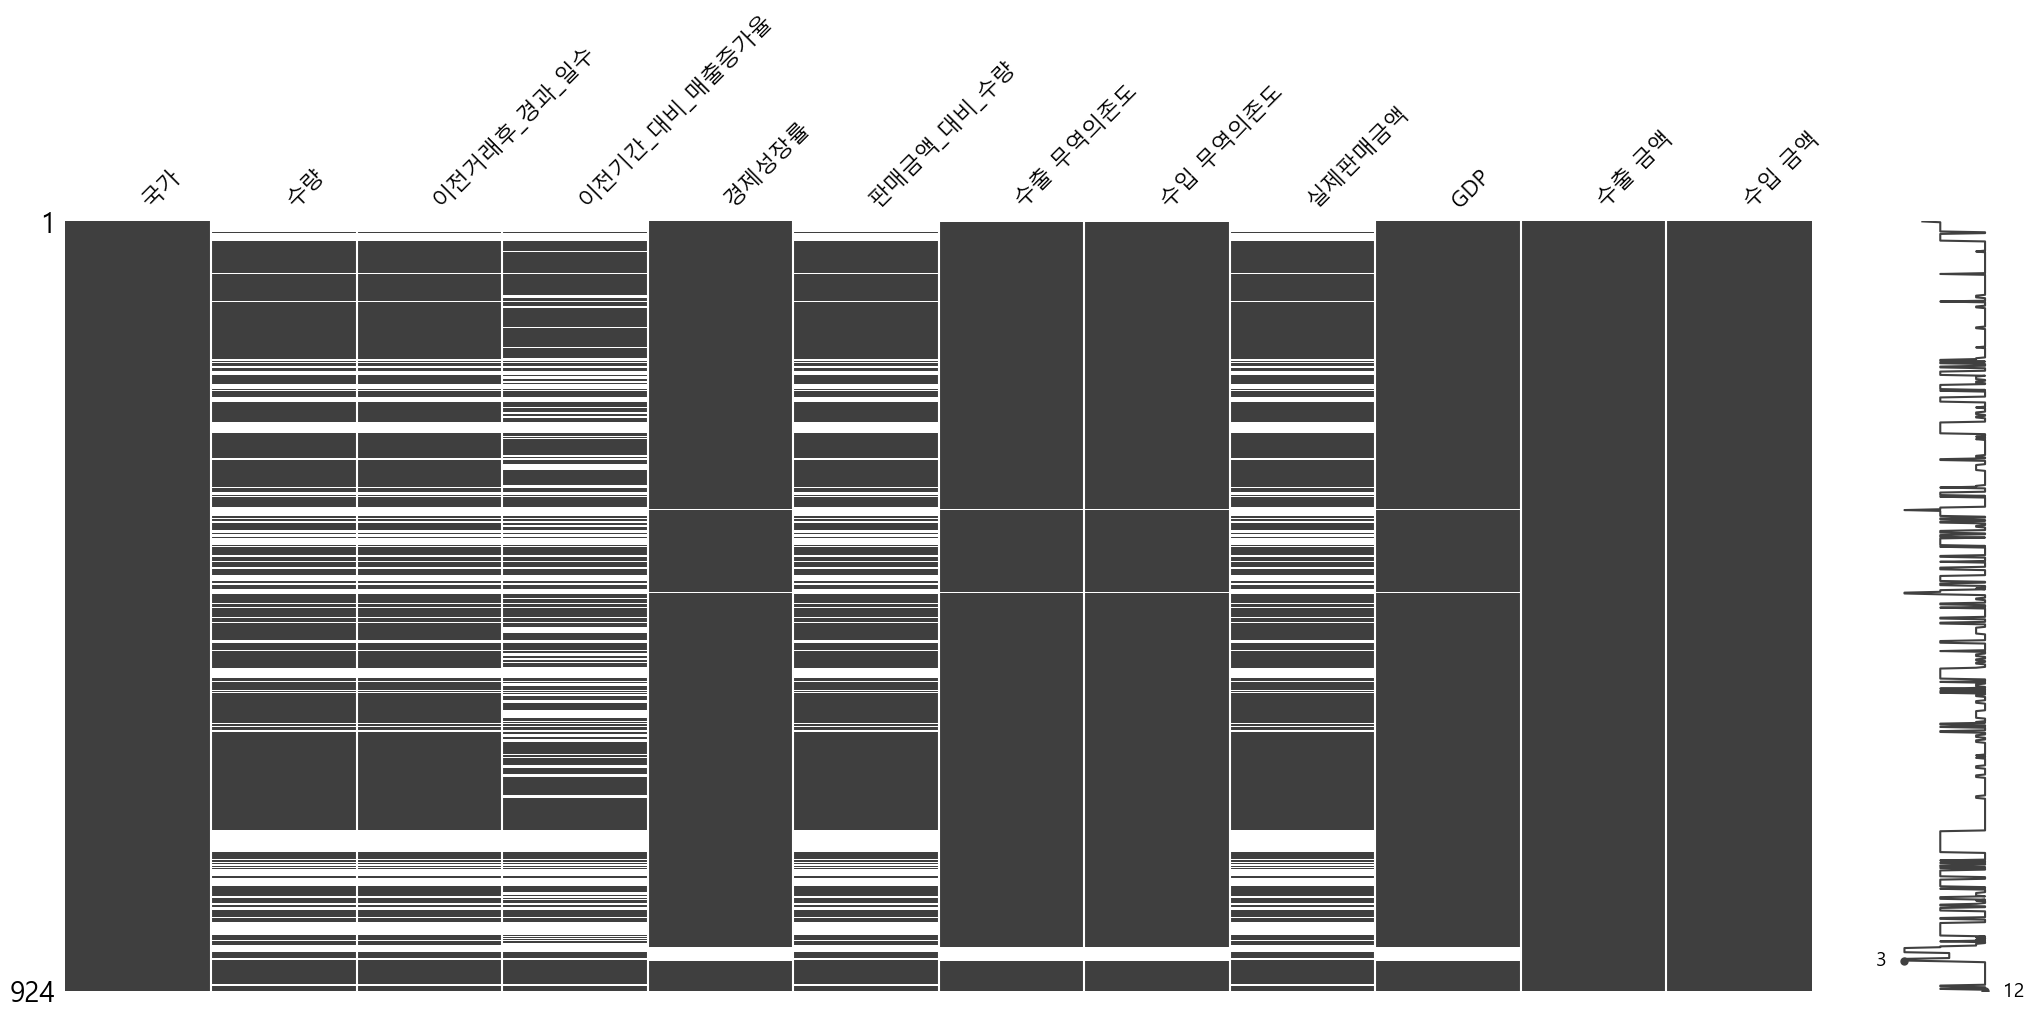

In [49]:
msno.matrix(df_clus)

In [50]:
#columns:['국가', '수량', '이전거래후_경과_일수', '이전기간_대비_매출증가율', '경제성장률', '판매금액_대비_수량', '수출 무역의존도', '수입 무역의존도', '실제판매금액', 'GDP', '수출 금액', '수입 금액']
#0으로
zero = ['수량', '이전거래후_경과_일수', '이전기간_대비_매출증가율', '판매금액_대비_수량', '실제판매금액']
df_clus[zero] = df_clus[zero].fillna(0)

#다른 결측치는 제거 
remove = ['경제성장률', 'GDP']
df_clus = df_clus.dropna(subset=remove)

<Axes: >

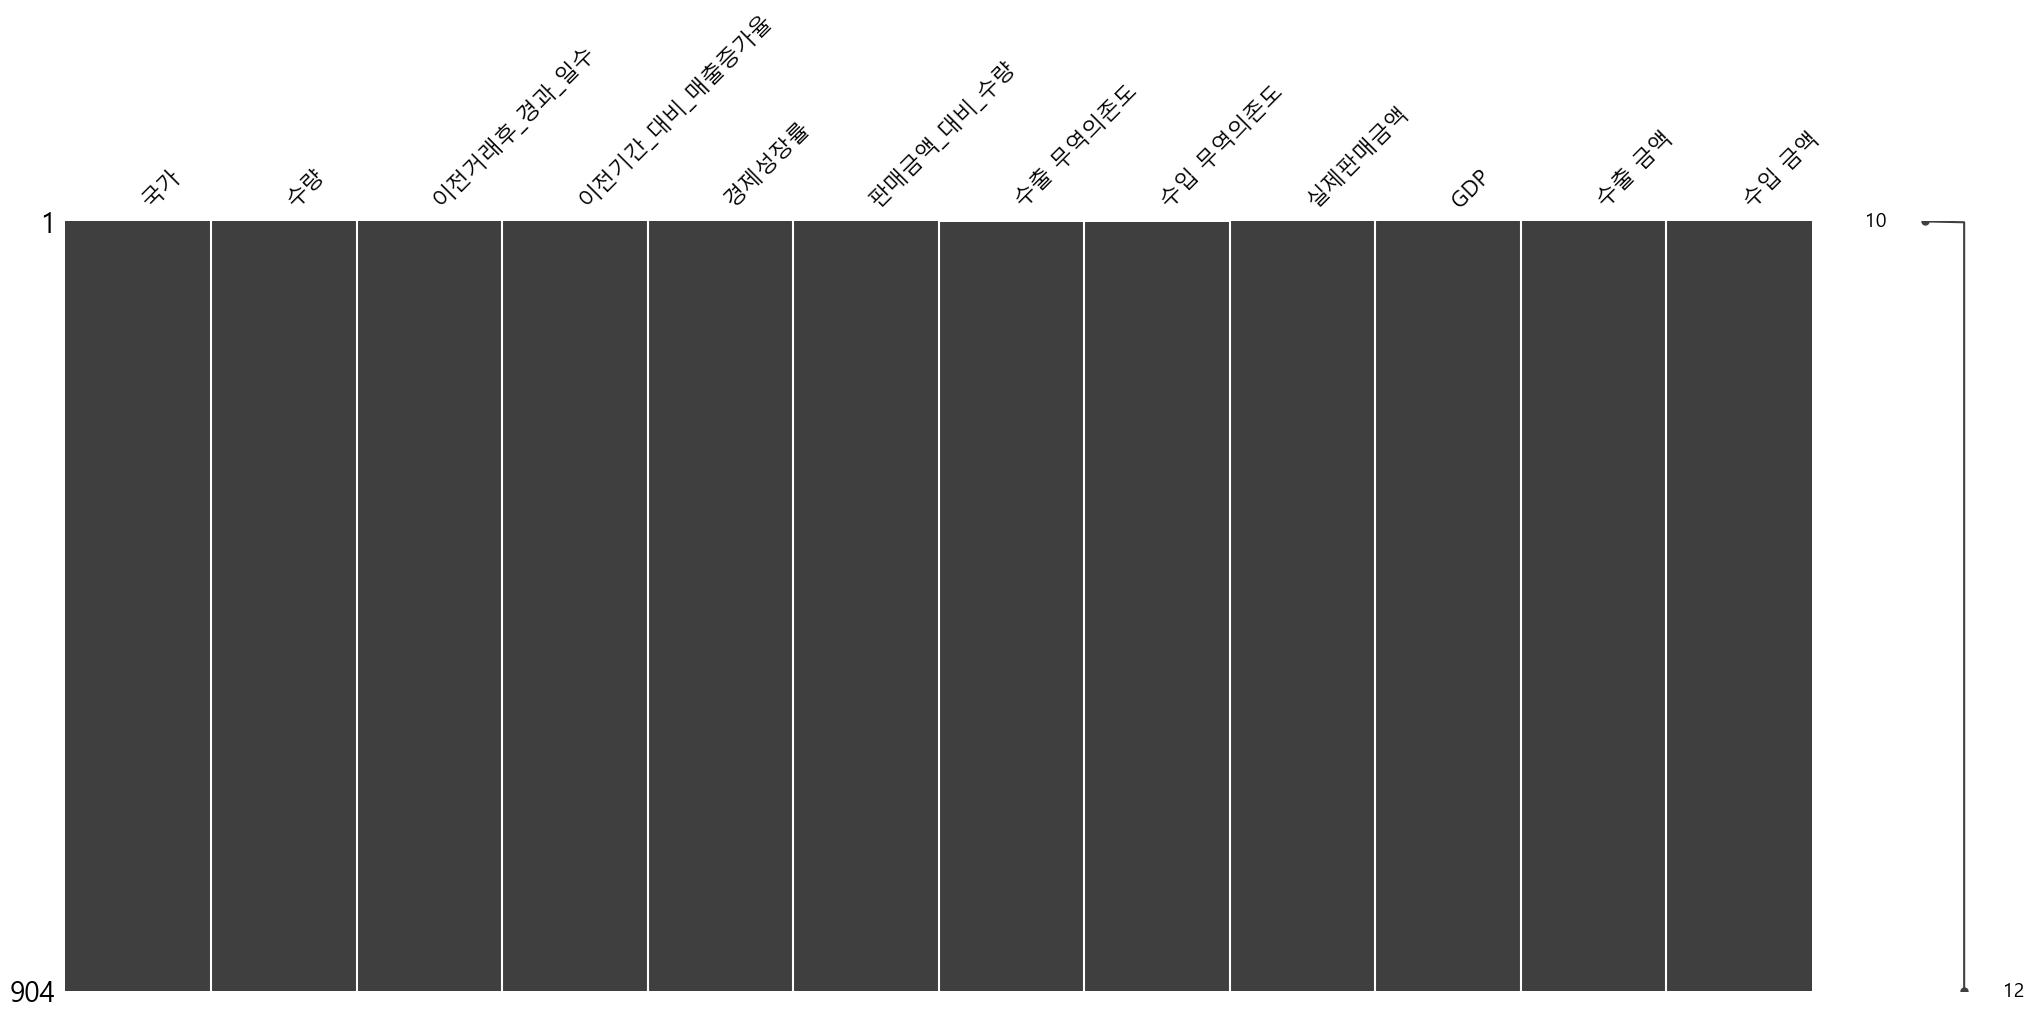

In [51]:
msno.matrix(df_clus)

In [52]:
print(df_clus['국가'].nunique())
print(df_clus['국가'].unique())

60
['괌' '나이지리아' '남아프리카공화국' '네덜란드' '노르웨이' '뉴질랜드' '대만' '덴마크' '독일' '라트비아' '러시아'
 '루마니아' '리투아니아' '말레이시아' '멕시코' '몽골' '미국' '방글라데시' '베트남' '벨기에' '불가리아' '브라질'
 '사우디아라비아' '세르비아' '스웨덴' '스위스' '스페인' '슬로베니아' '싱가포르' '아랍에미리트' '아르헨티나' '아이티'
 '아일랜드' '알제리' '에스토니아' '엘살바도르' '영국' '오스트리아' '우크라이나' '이스라엘' '이집트' '이탈리아'
 '인도' '인도네시아' '일본' '중국' '체코' '칠레' '캐나다' '쿠웨이트' '크로아티아' '태국' '페루' '폴란드'
 '프랑스' '피지' '핀란드' '필리핀' '헝가리' '홍콩']


In [53]:
#시간요소 제거
df_clus['수량'] = pd.to_numeric(df_clus['수량'], errors='coerce')
df_clus['이전거래후_경과_일수'] = pd.to_numeric(df_clus['이전거래후_경과_일수'], errors='coerce')
df_clus['이전기간_대비_매출증가율'] = pd.to_numeric(df_clus['이전기간_대비_매출증가율'], errors='coerce')
df_clus['경제성장률'] = pd.to_numeric(df_clus['경제성장률'], errors='coerce')
df_clus['실제판매금액'] = pd.to_numeric(df_clus['실제판매금액'], errors='coerce')
df_clus['GDP'] = pd.to_numeric(df_clus['GDP'], errors='coerce')
df_clus['수출 금액'] = pd.to_numeric(df_clus['수출 금액'], errors='coerce')
df_clus['수입 금액'] = pd.to_numeric(df_clus['수입 금액'], errors='coerce')

agg_functions = {
    '수량': 'sum',
    '이전거래후_경과_일수': 'mean',
    '이전기간_대비_매출증가율': 'mean',
    '경제성장률': 'mean',
    '실제판매금액': 'sum',
    'GDP': 'sum', 
    '수출 금액': 'sum',
    '수입 금액': 'sum'
}

df_clus_grp = df_clus.groupby('국가').agg(agg_functions).reset_index()

In [54]:
#파생변수 다시 생성 
df_clus_grp['판매금액_대비_수량'] = df_clus_grp['수량'] / df_clus_grp['실제판매금액']
df_clus_grp['수출 무역의존도'] = df_clus_grp['수출 금액'] / df_clus_grp['GDP']
df_clus_grp['수입 무역의존도'] = df_clus_grp['수입 금액'] / df_clus_grp['GDP']

In [55]:
df_clus_grp

,국가,수량,이전거래후_경과_일수,이전기간_대비_매출증가율,경제성장률,실제판매금액,GDP,수출 금액,수입 금액,판매금액_대비_수량,수출 무역의존도,수입 무역의존도
0,괌,0.0,0.000000,0.000000,NaN,0.0,0.000000e+00,0,0,NaN,NaN,NaN
1,나이지리아,0.0,0.000000,0.000000,3.3,0.0,4.774000e+11,5000,0,NaN,1.047340e-08,0.000000e+00
2,남아프리카공화국,0.0,0.000000,0.000000,2.0,0.0,4.059000e+11,3000,0,NaN,7.390983e-09,0.000000e+00
3,네덜란드,3.0,6.846154,0.084014,4.5,17820000.0,1.288430e+13,217000,57000,1.683502e-07,1.684220e-08,4.423989e-09
4,노르웨이,0.0,0.000000,0.000000,3.3,0.0,5.793000e+11,4000,0,NaN,6.904885e-09,0.000000e+00
5,뉴질랜드,0.0,0.000000,0.000000,2.2,0.0,1.730400e+12,81000,25000,NaN,4.680999e-08,1.444753e-08
6,대만,245.0,4.506849,inf,2.4,358665300.0,5.558220e+13,1988000,29453000,6.830881e-07,3.576685e-08,5.298999e-07
7,덴마크,725.0,5.289855,inf,3.8,205343100.0,2.728260e+13,1098000,215000,3.530676e-06,4.024543e-08,7.880481e-09
8,독일,12.0,35.714286,1.693461,1.8,15151050.0,5.701080e+13,1503000,35484000,7.920243e-07,2.636343e-08,6.224084e-07
9,라트비아,0.0,0.000000,0.000000,2.0,0.0,4.120000e+10,1000,0,NaN,2.427184e-08,0.000000e+00


In [56]:
#VIF로 거른 변수들: ['수량', '이전거래후_경과_일수', '이전기간_대비_매출증가율', '경제성장률', '판매금액_대비_수량', '수출 무역의존도', '수입 무역의존도', '실제판매금액']
df_clus_grp = df_clus_grp[['국가', '수량', '이전거래후_경과_일수', '이전기간_대비_매출증가율', '경제성장률', '판매금액_대비_수량', '수출 무역의존도', '수입 무역의존도', '실제판매금액']]

<Axes: >

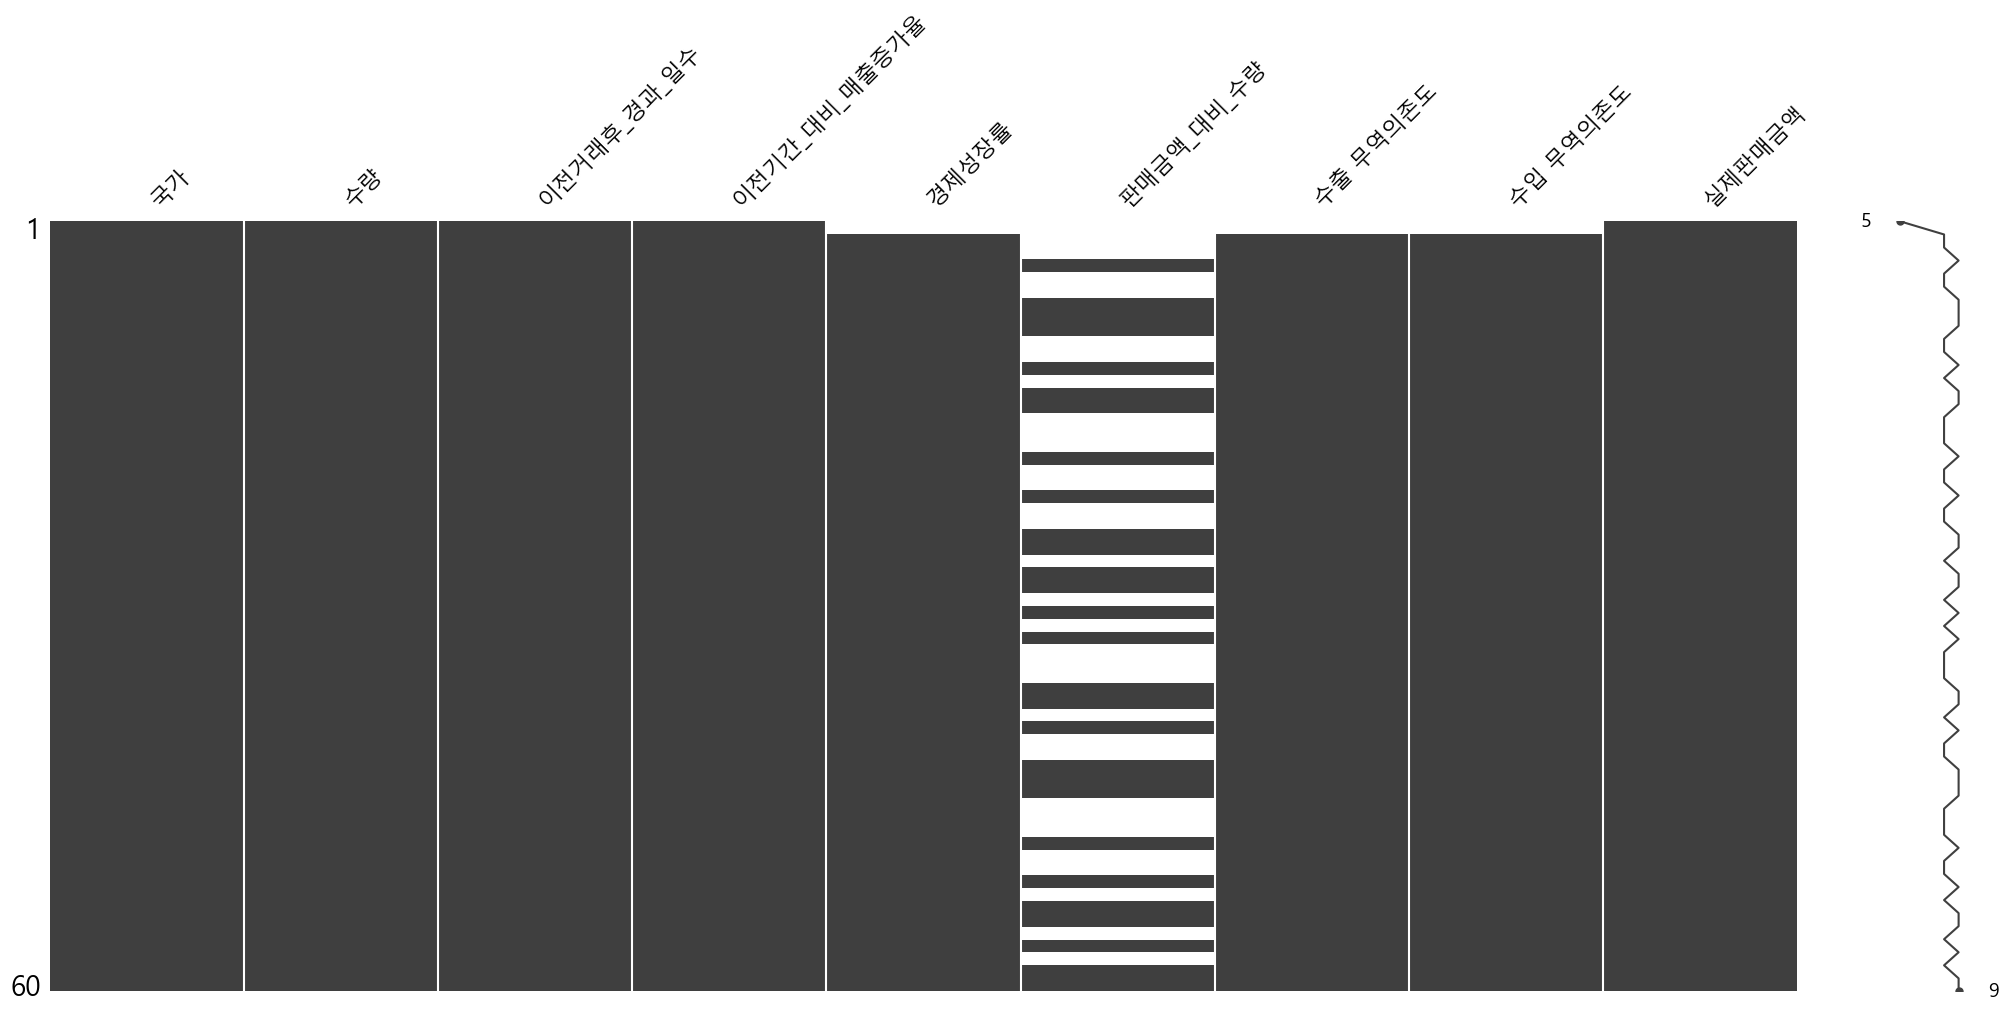

In [57]:
msno.matrix(df_clus_grp)

In [58]:
#0으로
zero = ['판매금액_대비_수량']
df_clus_grp[zero] = df_clus_grp[zero].fillna(0)

#다른 결측치는 제거 
remove = ['경제성장률', '수출 무역의존도', '수입 무역의존도']
df_clus_grp = df_clus_grp.dropna(subset=remove)

In [59]:
df_clus_grp.isna().sum()

국가               0
수량               0
이전거래후_경과_일수      0
이전기간_대비_매출증가율    0
경제성장률            0
판매금액_대비_수량       0
수출 무역의존도         0
수입 무역의존도         0
실제판매금액           0
dtype: int64

<Axes: >

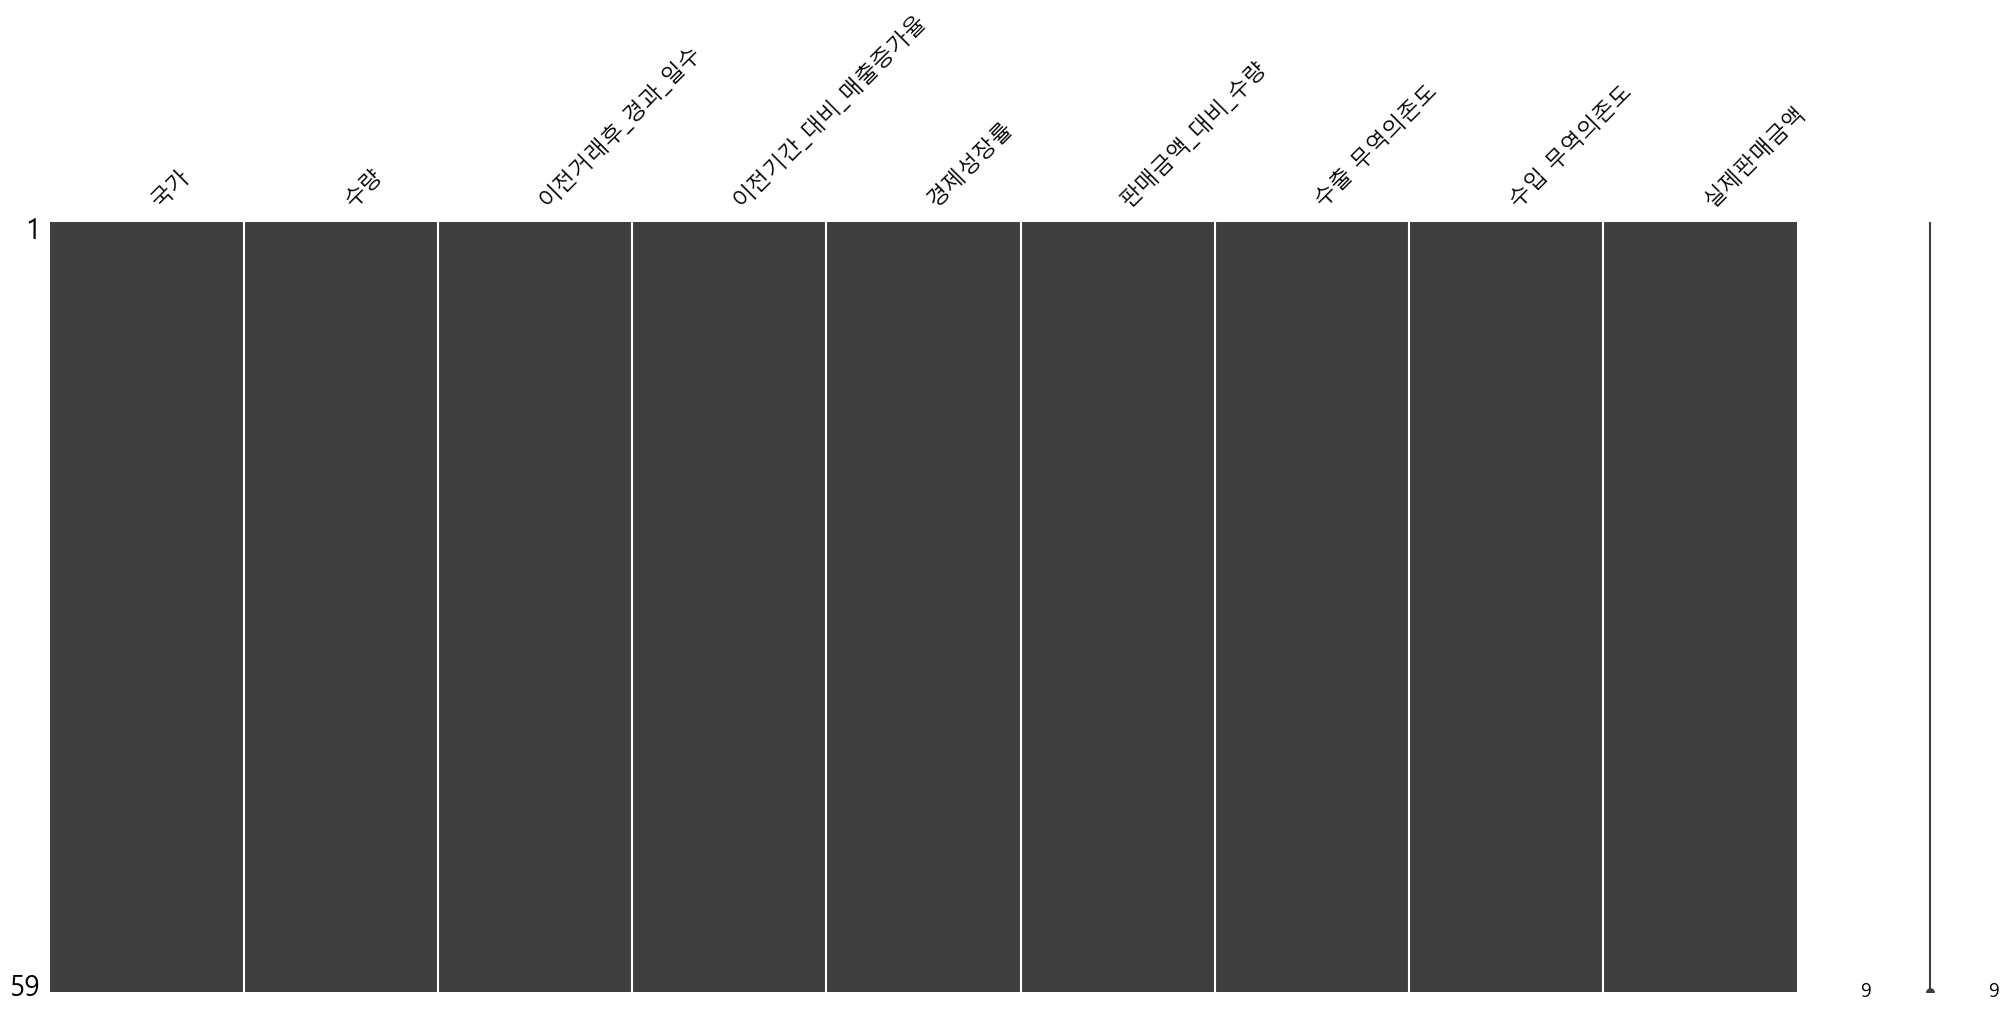

In [60]:
msno.matrix(df_clus_grp)

In [61]:
print(df_clus_grp['국가'].nunique())
print(df_clus_grp['국가'].unique())   #총 59개 국가에 대해 클러스터링 진행 (거래국가 + 비거래국가)

59
['나이지리아' '남아프리카공화국' '네덜란드' '노르웨이' '뉴질랜드' '대만' '덴마크' '독일' '라트비아' '러시아'
 '루마니아' '리투아니아' '말레이시아' '멕시코' '몽골' '미국' '방글라데시' '베트남' '벨기에' '불가리아' '브라질'
 '사우디아라비아' '세르비아' '스웨덴' '스위스' '스페인' '슬로베니아' '싱가포르' '아랍에미리트' '아르헨티나' '아이티'
 '아일랜드' '알제리' '에스토니아' '엘살바도르' '영국' '오스트리아' '우크라이나' '이스라엘' '이집트' '이탈리아'
 '인도' '인도네시아' '일본' '중국' '체코' '칠레' '캐나다' '쿠웨이트' '크로아티아' '태국' '페루' '폴란드'
 '프랑스' '피지' '핀란드' '필리핀' '헝가리' '홍콩']


## 군집분석 

In [62]:
df_clus_grp

,국가,수량,이전거래후_경과_일수,이전기간_대비_매출증가율,경제성장률,판매금액_대비_수량,수출 무역의존도,수입 무역의존도,실제판매금액
1,나이지리아,0.0,0.000000,0.000000,3.3,0.000000e+00,1.047340e-08,0.000000e+00,0.0
2,남아프리카공화국,0.0,0.000000,0.000000,2.0,0.000000e+00,7.390983e-09,0.000000e+00,0.0
3,네덜란드,3.0,6.846154,0.084014,4.5,1.683502e-07,1.684220e-08,4.423989e-09,17820000.0
4,노르웨이,0.0,0.000000,0.000000,3.3,0.000000e+00,6.904885e-09,0.000000e+00,0.0
5,뉴질랜드,0.0,0.000000,0.000000,2.2,0.000000e+00,4.680999e-08,1.444753e-08,0.0
6,대만,245.0,4.506849,inf,2.4,6.830881e-07,3.576685e-08,5.298999e-07,358665300.0
7,덴마크,725.0,5.289855,inf,3.8,3.530676e-06,4.024543e-08,7.880481e-09,205343100.0
8,독일,12.0,35.714286,1.693461,1.8,7.920243e-07,2.636343e-08,6.224084e-07,15151050.0
9,라트비아,0.0,0.000000,0.000000,2.0,0.000000e+00,2.427184e-08,0.000000e+00,0.0
10,러시아,0.0,0.000000,0.000000,-2.1,0.000000e+00,1.450634e-09,3.347616e-10,0.0


In [63]:
#inf 0으로 대체하기 
df_clus_grp.replace([float('inf'), float('-inf')], 0, inplace=True)
df_clus_grp

,국가,수량,이전거래후_경과_일수,이전기간_대비_매출증가율,경제성장률,판매금액_대비_수량,수출 무역의존도,수입 무역의존도,실제판매금액
1,나이지리아,0.0,0.000000,0.000000,3.3,0.000000e+00,1.047340e-08,0.000000e+00,0.0
2,남아프리카공화국,0.0,0.000000,0.000000,2.0,0.000000e+00,7.390983e-09,0.000000e+00,0.0
3,네덜란드,3.0,6.846154,0.084014,4.5,1.683502e-07,1.684220e-08,4.423989e-09,17820000.0
4,노르웨이,0.0,0.000000,0.000000,3.3,0.000000e+00,6.904885e-09,0.000000e+00,0.0
5,뉴질랜드,0.0,0.000000,0.000000,2.2,0.000000e+00,4.680999e-08,1.444753e-08,0.0
6,대만,245.0,4.506849,0.000000,2.4,6.830881e-07,3.576685e-08,5.298999e-07,358665300.0
7,덴마크,725.0,5.289855,0.000000,3.8,3.530676e-06,4.024543e-08,7.880481e-09,205343100.0
8,독일,12.0,35.714286,1.693461,1.8,7.920243e-07,2.636343e-08,6.224084e-07,15151050.0
9,라트비아,0.0,0.000000,0.000000,2.0,0.000000e+00,2.427184e-08,0.000000e+00,0.0
10,러시아,0.0,0.000000,0.000000,-2.1,0.000000e+00,1.450634e-09,3.347616e-10,0.0


In [65]:
df_clus_grp.to_csv('결과/df_cluster.csv', index=False)

In [130]:
df_clus_grp.describe()

,수량,이전거래후_경과_일수,이전기간_대비_매출증가율,경제성장률,판매금액_대비_수량,수출 무역의존도,수입 무역의존도,실제판매금액
count,59.000000,59.000000,59.000000,59.000000,59.000000,5.900000e+01,5.900000e+01,5.900000e+01
mean,121.423729,13.674453,0.677981,3.496610,0.000002,1.119026e-07,1.997146e-07,4.711791e+07
std,252.742148,46.795231,2.938552,5.353019,0.000005,1.890938e-07,1.065814e-06,8.358705e+07
min,0.000000,0.000000,-0.166540,-29.100000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000,0.000000,0.000000,2.350000,0.000000,1.189046e-08,0.000000e+00,0.000000e+00
50%,0.000000,0.000000,0.000000,3.300000,0.000000,4.680999e-08,4.677986e-09,0.000000e+00
75%,83.000000,13.494118,0.000000,5.350000,0.000001,1.028997e-07,2.330452e-08,4.625100e+07
max,1062.000000,356.000000,19.828276,16.100000,0.000026,1.095262e-06,8.165559e-06,3.586653e+08


In [132]:
#0이 너무 많은 칼럼들 제거: 이전기간_대비_매출증가율, 판매금액 대비 수량 
#테스콤 매출과 직접적으로 연관된 변수 제거: '이전거래후_경과_일수', '실제판매금액', '수량'
df_clus_filtered = df_clus_grp[['국가', '경제성장률', '수출 무역의존도', '수입 무역의존도']]

#### 클러스터링 개수 설정
- https://hongl.tistory.com/141

In [134]:
#df_clus_grp: 국가 포함
#df_cluster: 국가 제외 
df_cluster = df_clus_filtered[['경제성장률', '수출 무역의존도', '수입 무역의존도']]

In [136]:
#변수 스케일링
from sklearn.preprocessing import StandardScaler
columns = ['경제성장률', '수출 무역의존도', '수입 무역의존도']

x = df_cluster.loc[:, columns].values

scaler = StandardScaler()
df_cluster = scaler.fit_transform(x)
df_cluster = pd.DataFrame(df_cluster, columns=columns)
df_cluster

,경제성장률,수출 무역의존도,수입 무역의존도
0,-0.037044,-0.541000,-0.188991
1,-0.281982,-0.557441,-0.188991
2,0.189053,-0.507031,-0.184804
3,-0.037044,-0.560034,-0.188991
4,-0.244300,-0.347189,-0.175319
5,-0.206617,-0.406091,0.312456
6,0.057163,-0.382203,-0.181533
7,-0.319665,-0.456247,0.399997
8,-0.281982,-0.467403,-0.188991
9,-1.054480,-0.589126,-0.188674


#### KMeans

In [256]:
df_cluster = df_cluster[['경제성장률', '수출 무역의존도', '수입 무역의존도']]

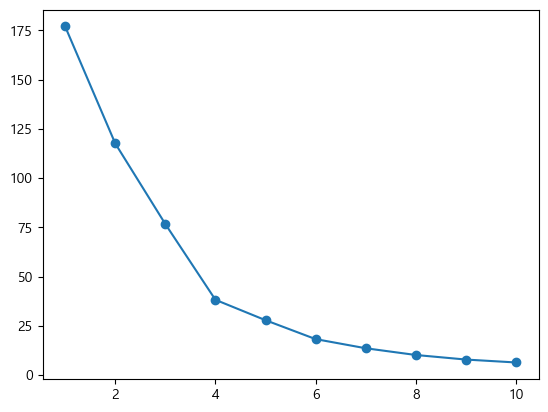

In [257]:
#elbow point method 
from sklearn.cluster import KMeans

inertia = []
for i in range(1, 11):
    kmeans_plus = KMeans(n_clusters=i, init='k-means++')
    kmeans_plus.fit(df_cluster)
    inertia.append(kmeans_plus.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.show()

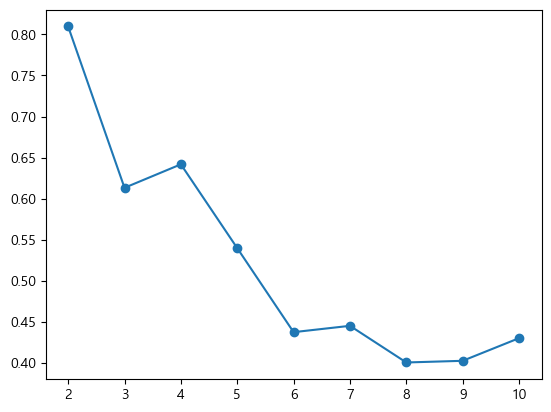

In [258]:
#silhouette method
from sklearn.metrics import silhouette_samples

silhouette_vals = []
for i in range(2, 11):
    kmeans_plus = KMeans(n_clusters=i, init='k-means++')
    pred = kmeans_plus.fit_predict(df_cluster)
    silhouette_vals.append(np.mean(silhouette_samples(df_cluster, pred, metric='euclidean')))

plt.plot(range(2, 11), silhouette_vals, marker='o')
plt.show()

군집개수 = 4

클러스터링 진행해서 타겟 국가 선정
- https://suy379.tistory.com/51

In [259]:
#KMeans
from sklearn.cluster import KMeans 
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans_clusters = kmeans.fit(df_cluster)
kmeans_labels = kmeans_clusters.labels_

df_cluster['kmeans_clusters'] = kmeans_clusters.labels_
df_cluster

,경제성장률,수출 무역의존도,수입 무역의존도,kmeans_clusters
0,-0.037044,-0.541000,-0.188991,1
1,-0.281982,-0.557441,-0.188991,1
2,0.189053,-0.507031,-0.184804,1
3,-0.037044,-0.560034,-0.188991,1
4,-0.244300,-0.347189,-0.175319,1
5,-0.206617,-0.406091,0.312456,1
6,0.057163,-0.382203,-0.181533,1
7,-0.319665,-0.456247,0.399997,1
8,-0.281982,-0.467403,-0.188991,1
9,-1.054480,-0.589126,-0.188674,1


In [260]:
from sklearn.metrics import silhouette_score

# pred는 클러스터링 결과
silhouette_avg = silhouette_score(df_cluster, kmeans_labels, metric='euclidean')

print(f"실루엣 점수: {silhouette_avg}")


실루엣 점수: 0.6653514354611522


In [261]:
df_cluster.groupby('kmeans_clusters').count()

,경제성장률,수출 무역의존도,수입 무역의존도
kmeans_clusters,,,
0,6,6,6
1,51,51,51
2,1,1,1
3,1,1,1


In [262]:
df_cluster.groupby('kmeans_clusters').mean()

,경제성장률,수출 무역의존도,수입 무역의존도
kmeans_clusters,,,
0,-0.102989,2.458193,-0.101636
1,0.113318,-0.292663,-0.132432
2,0.980392,0.773520,7.538112
3,-6.141658,-0.596863,-0.174251


군집 순위:
- 경제성장률: 2 > 1 > 0 > 3
- 수출 무역의존도: 0 > 2 > 1 > 3
- 수입 무역의존도: 2 > 0 > 1 > 3
- target cluster: 클러스터 0

In [264]:
df_cluster.to_csv('데이터/kmeans.csv', index=False)

그래프 그리기 위해 PCA를 통해 변수를 2차원으로 축소하기

In [265]:
from sklearn.decomposition import PCA
X = df_cluster.copy()

#객체
pca = PCA(n_components=2)

#적용
pca.fit(X)
x_pca = pca.transform(X)
x_pca

array([[-4.64400775e-01,  1.68727863e-01],
       [-6.12518519e-01,  1.73160634e-01],
       [-3.13805429e-01,  1.57456774e-01],
       [-4.76294146e-01,  1.79275699e-01],
       [-4.52984231e-01,  6.79315823e-02],
       [-2.20651916e-01,  4.78269313e-01],
       [-3.08367003e-01,  8.82901798e-02],
       [-2.71116498e-01,  5.71561029e-01],
       [-5.56256877e-01,  1.23264052e-01],
       [-1.06689614e+00,  1.76209501e-01],
       [-2.68858171e-01,  1.41762933e-01],
       [-6.40913036e-01,  2.05050380e-01],
       [ 4.67149828e+00,  5.74018876e+00],
       [-4.73364911e-01,  1.60677572e-01],
       [ 1.43250622e+00, -1.51104779e+00],
       [-3.92476794e-01,  8.64131382e-02],
       [-9.63772088e-02,  2.13360108e-01],
       [ 2.36430536e+00, -1.99533107e+00],
       [-5.03041983e-01,  1.95902131e-01],
       [ 3.72598544e-01, -5.63815363e-01],
       [-4.88655699e-01,  1.51184000e-01],
       [ 1.16533011e-01,  1.81104427e-01],
       [ 9.97465802e-01, -1.36931707e+00],
       [-5.

In [266]:
#x_pca를 보기 쉽게 데이터프레임으로 만들기
pca_df = pd.DataFrame(x_pca)
pca_df['kmeans_clusters'] = df_cluster['kmeans_clusters'] 
pca_df.head()

,0,1,kmeans_clusters
0,-0.464401,0.168728,1
1,-0.612519,0.173161,1
2,-0.313805,0.157457,1
3,-0.476294,0.179276,1
4,-0.452984,0.067932,1


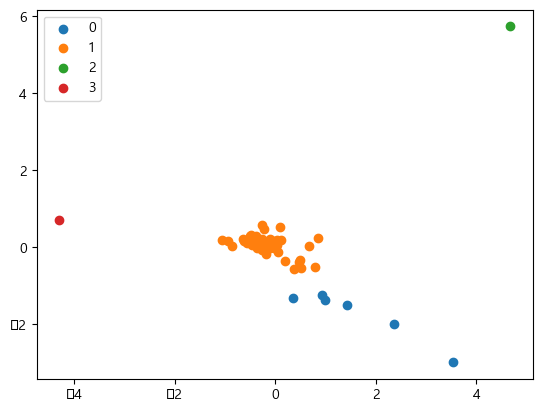

In [267]:
for i in sorted(pca_df['kmeans_clusters'].unique()):
    tmp = pca_df.loc[pca_df['kmeans_clusters'] == i] #해당하는 클러스터 번호일 때 그림을 그리고, for문 실행하며 위에 덧그림 
    plt.scatter(tmp[0], tmp[1])
    plt.legend(sorted(pca_df['kmeans_clusters'].unique()))

#### KMedoids

In [271]:
df_cluster = df_cluster[['경제성장률', '수출 무역의존도', '수입 무역의존도']]

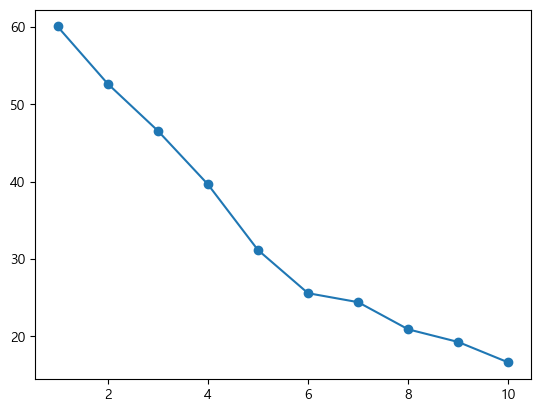

In [280]:
#elbow point method 
from sklearn_extra.cluster import KMedoids

inertia = []
for i in range(1, 11):
    kmedoids_plus = KMedoids(n_clusters=i, init='k-medoids++')
    kmedoids_plus.fit(df_cluster)
    inertia.append(kmedoids_plus.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.show()

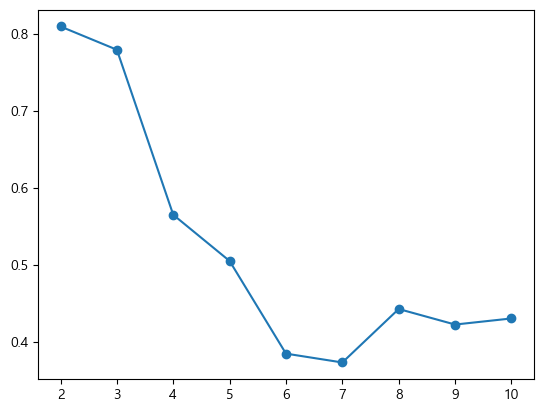

In [281]:
#silhouette method
from sklearn.metrics import silhouette_samples

silhouette_vals = []
for i in range(2, 11):
    kmedoids_plus = KMedoids(n_clusters=i, init='k-medoids++')
    pred = kmedoids_plus.fit_predict(df_cluster)
    silhouette_vals.append(np.mean(silhouette_samples(df_cluster, pred, metric='euclidean')))

plt.plot(range(2, 11), silhouette_vals, marker='o')
plt.show()

In [282]:
from sklearn_extra.cluster import KMedoids
kmedoids = KMedoids(n_clusters=3, random_state=0)
kmedoids_clusters = kmedoids.fit(df_cluster)
kmedoids_labels = kmedoids_clusters.labels_

df_cluster['kmedoids_clusters'] = kmedoids_clusters.labels_
df_cluster


,경제성장률,수출 무역의존도,수입 무역의존도,kmedoids_clusters
0,-0.037044,-0.541000,-0.188991,0
1,-0.281982,-0.557441,-0.188991,0
2,0.189053,-0.507031,-0.184804,0
3,-0.037044,-0.560034,-0.188991,0
4,-0.244300,-0.347189,-0.175319,0
5,-0.206617,-0.406091,0.312456,0
6,0.057163,-0.382203,-0.181533,0
7,-0.319665,-0.456247,0.399997,0
8,-0.281982,-0.467403,-0.188991,0
9,-1.054480,-0.589126,-0.188674,0


In [283]:
from sklearn.metrics import silhouette_score

# pred는 클러스터링 결과
silhouette_avg = silhouette_score(df_cluster, kmedoids_labels, metric='euclidean')

print(f"실루엣 점수: {silhouette_avg}")

실루엣 점수: 0.4785536694484111


In [284]:
df_cluster.groupby('kmedoids_clusters').count()

,경제성장률,수출 무역의존도,수입 무역의존도
kmedoids_clusters,,,
0,32,32,32
1,19,19,19
2,8,8,8


In [285]:
df_cluster.groupby('kmedoids_clusters').mean()

,경제성장률,수출 무역의존도,수입 무역의존도
kmedoids_clusters,,,
0,-0.409751,-0.393404,-0.100608
1,0.709670,-0.194456,0.221100
2,-0.046465,2.035447,-0.122682


In [286]:
df_cluster.to_csv('데이터/kmedoids.csv', index=False)

In [287]:
from sklearn.decomposition import PCA
X = df_cluster.copy()

#객체
pca = PCA(n_components=2)

#적용
pca.fit(X)
x_pca = pca.transform(X)
x_pca

array([[-0.73538084,  0.26585678],
       [-0.85055431,  0.13895601],
       [-0.61468593,  0.37610155],
       [-0.74846421,  0.2754892 ],
       [-0.68527416,  0.06190111],
       [-0.53937046,  0.41737009],
       [-0.5836703 ,  0.24216263],
       [-0.59120383,  0.43505573],
       [-0.78866337,  0.09338984],
       [-1.19982021, -0.27127779],
       [-0.10040028,  0.17210499],
       [-0.88093955,  0.15691776],
       [ 3.77422767,  4.77148666],
       [-0.73849823,  0.23812634],
       [ 2.04191873, -1.27566354],
       [-0.62908076,  0.06329848],
       [ 0.00483233,  0.46916712],
       [ 2.94429096, -1.39753949],
       [-0.77467161,  0.28042352],
       [ 1.13166173, -0.83348152],
       [-0.7473659 ,  0.20954356],
       [ 0.18019889,  0.60085563],
       [ 1.65520447, -1.39805799],
       [-0.78473491,  0.29048934],
       [-0.75766879,  0.25630786],
       [-0.11131446,  0.29937384],
       [-0.01292217,  0.20540622],
       [-0.02405281, -0.19146729],
       [ 0.07959018,

In [288]:
#x_pca를 보기 쉽게 데이터프레임으로 만들기
pca_df = pd.DataFrame(x_pca)
pca_df['kmedoids_clusters'] = df_cluster['kmedoids_clusters'] 
pca_df.head()

,0,1,kmedoids_clusters
0,-0.735381,0.265857,0
1,-0.850554,0.138956,0
2,-0.614686,0.376102,0
3,-0.748464,0.275489,0
4,-0.685274,0.061901,0


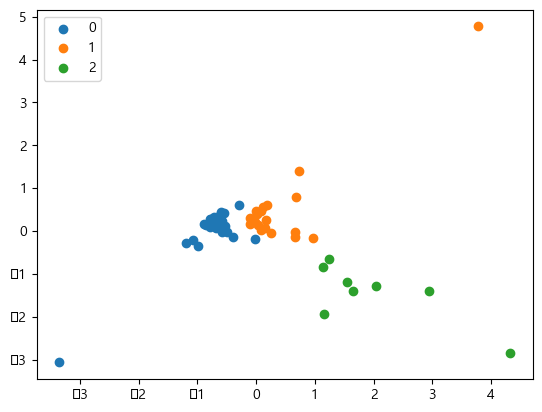

In [289]:
for i in sorted(pca_df['kmedoids_clusters'].unique()):
    tmp = pca_df.loc[pca_df['kmedoids_clusters'] == i] #해당하는 클러스터 번호일 때 그림을 그리고, for문 실행하며 위에 덧그림 
    plt.scatter(tmp[0], tmp[1])
    plt.legend(sorted(pca_df['kmedoids_clusters'].unique()))

#### Hierarchal 

In [300]:
df_cluster = df_cluster[['경제성장률', '수출 무역의존도', '수입 무역의존도']]

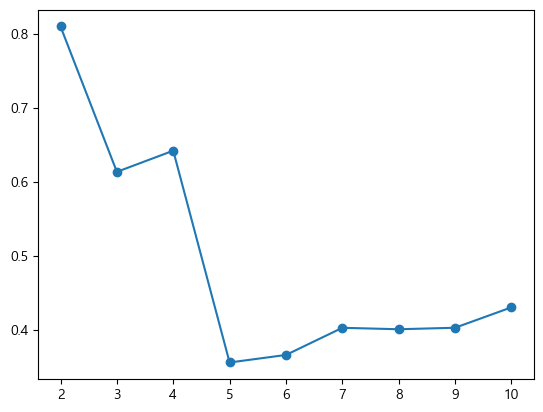

In [301]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples

silhouette_vals = []
for i in range(2, 11):
    hier_plus = AgglomerativeClustering(n_clusters=i)
    pred = hier_plus.fit_predict(df_cluster)
    silhouette_avg = silhouette_score(df_cluster, pred)
    silhouette_vals.append(silhouette_avg)

plt.plot(range(2, 11), silhouette_vals, marker='o')
plt.show()

In [303]:
from sklearn.cluster import AgglomerativeClustering
hier = AgglomerativeClustering(n_clusters=4)
hier_clusters = hier.fit(df_cluster)
hier_labels = hier_clusters.labels_

df_cluster['hier_clusters'] = hier_clusters.labels_
df_cluster

,경제성장률,수출 무역의존도,수입 무역의존도,hier_clusters
0,-0.037044,-0.541000,-0.188991,0
1,-0.281982,-0.557441,-0.188991,0
2,0.189053,-0.507031,-0.184804,0
3,-0.037044,-0.560034,-0.188991,0
4,-0.244300,-0.347189,-0.175319,0
5,-0.206617,-0.406091,0.312456,0
6,0.057163,-0.382203,-0.181533,0
7,-0.319665,-0.456247,0.399997,0
8,-0.281982,-0.467403,-0.188991,0
9,-1.054480,-0.589126,-0.188674,0


In [304]:
df_cluster.groupby('hier_clusters').count()

,경제성장률,수출 무역의존도,수입 무역의존도
hier_clusters,,,
0,51,51,51
1,1,1,1
2,6,6,6
3,1,1,1


In [305]:
df_cluster.groupby('hier_clusters').mean()

,경제성장률,수출 무역의존도,수입 무역의존도
hier_clusters,,,
0,0.113318,-0.292663,-0.132432
1,-6.141658,-0.596863,-0.174251
2,-0.102989,2.458193,-0.101636
3,0.980392,0.773520,7.538112


In [306]:
df_cluster.to_csv('데이터/hierarchal.csv', index=False)

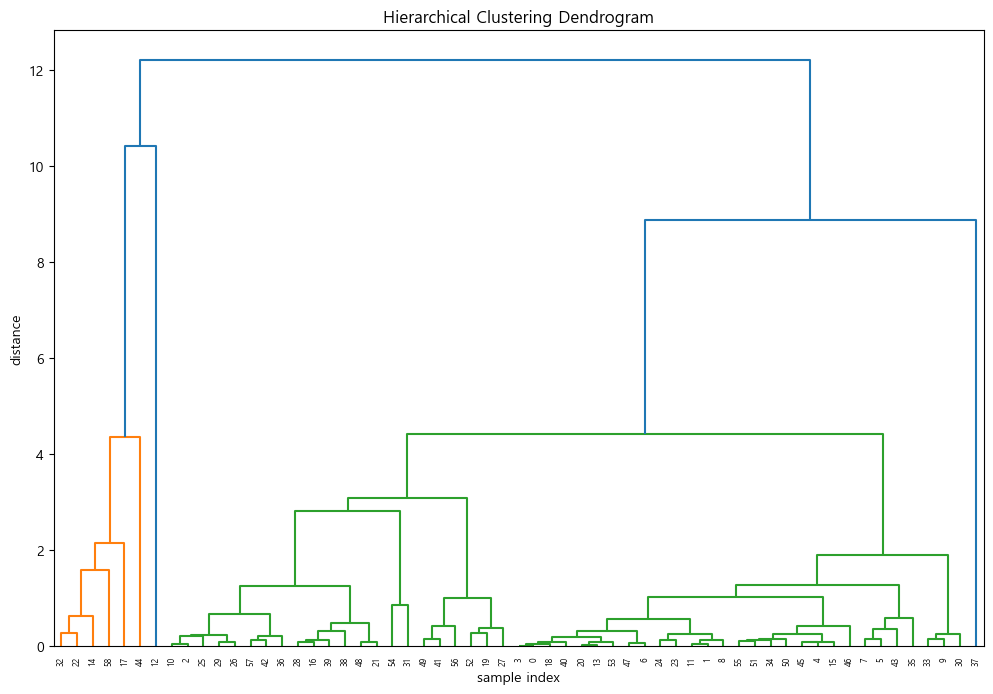

In [308]:
from scipy.cluster.hierarchy import dendrogram, linkage

# 덴드로그램 생성
linked = linkage(df_cluster, 'ward')
plt.figure(figsize=(12, 8))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
plt.show()

#### GMM

In [313]:
df_cluster = df_cluster[['경제성장률', '수출 무역의존도', '수입 무역의존도']]

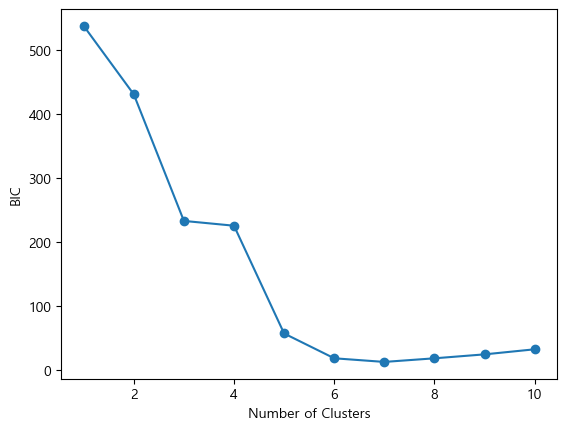

In [315]:
#elbow point method 
from sklearn.mixture import GaussianMixture
inertia = []
for i in range(1, 11):
    gmm_plus = GaussianMixture(n_components=i, random_state=0)
    gmm_clusters = gmm_plus.fit_predict(df_cluster)
    inertia.append(gmm_plus.bic(df_cluster))  # BIC 값을 사용할 수 있습니다.

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC')  # 또는 AIC를 사용할 수 있습니다.
plt.show()


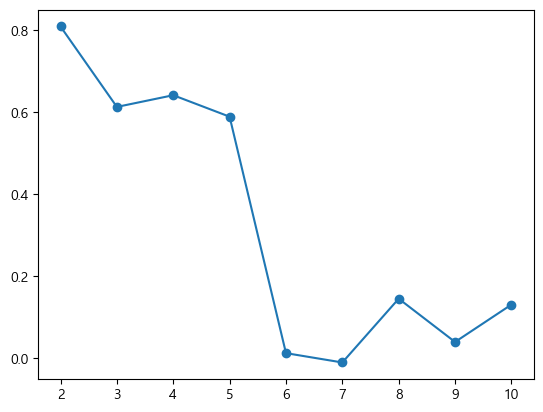

In [311]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples

silhouette_vals = []
for i in range(2, 11):
    gmm_plus = GaussianMixture(n_components=i)
    pred = gmm_plus.fit_predict(df_cluster)
    silhouette_avg = silhouette_score(df_cluster, pred)
    silhouette_vals.append(silhouette_avg)

plt.plot(range(2, 11), silhouette_vals, marker='o')
plt.show()

In [317]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4, random_state=0)
gmm_clusters = gmm.fit_predict(df_cluster)

df_cluster['gmm_clusters'] = gmm_clusters
df_cluster

,경제성장률,수출 무역의존도,수입 무역의존도,gmm_clusters
0,-0.037044,-0.541000,-0.188991,1
1,-0.281982,-0.557441,-0.188991,1
2,0.189053,-0.507031,-0.184804,1
3,-0.037044,-0.560034,-0.188991,1
4,-0.244300,-0.347189,-0.175319,1
5,-0.206617,-0.406091,0.312456,1
6,0.057163,-0.382203,-0.181533,1
7,-0.319665,-0.456247,0.399997,1
8,-0.281982,-0.467403,-0.188991,1
9,-1.054480,-0.589126,-0.188674,1


In [319]:
df_cluster.groupby('gmm_clusters').count()

,경제성장률,수출 무역의존도,수입 무역의존도
gmm_clusters,,,
0,6,6,6
1,51,51,51
2,1,1,1
3,1,1,1


In [318]:
df_cluster.groupby('gmm_clusters').mean()

,경제성장률,수출 무역의존도,수입 무역의존도
gmm_clusters,,,
0,-0.102989,2.458193,-0.101636
1,0.113318,-0.292663,-0.132432
2,0.980392,0.773520,7.538112
3,-6.141658,-0.596863,-0.174251


In [320]:
df_cluster.to_csv('데이터/gmm.csv', index=False)

In [323]:
#클러스터링 원본 데이터프레임 저장
df_cluster = df_cluster[['경제성장률', '수출 무역의존도', '수입 무역의존도']]
country = df_clus_grp[['국가']]

df_cluster.to_csv('데이터/df_cluster.csv', index=False)
country.to_csv('데이터/country.csv', index=False)